In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('../data/trade_df.csv', index_col='Date', parse_dates=True)

In [8]:
# calculate daily log return
df['btc_return'] = np.log(df.btc_close/df.btc_close.shift(1))

In [13]:
# add 8 btc return lags to reflect best AR order from AIC score in ARIMA Models notebook
for lag in range(1,9):
    df[f'btc_lag{lag}'] = df.btc_return.shift(lag)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1656 entries, 2015-08-07 to 2020-02-17
Data columns (total 43 columns):
btc_close               1656 non-null float64
spx_close               1656 non-null float64
mchi_close              1656 non-null float64
eem_close               1656 non-null float64
gld_close               1656 non-null float64
agg_close               1656 non-null float64
tips_close              1656 non-null float64
vix_close               1656 non-null float64
iai_value               1639 non-null float64
eth_close               1656 non-null float64
7D                      1656 non-null float64
14D                     1656 non-null float64
20D                     1656 non-null float64
50D                     1656 non-null float64
rsi7                    1649 non-null float64
rsi14                   1642 non-null float64
rsi20                   1636 non-null float64
rsi50                   1606 non-null float64
mchi_close_coint        1656 non-null float64
e

In [28]:
col_list = ['7D','14D','20D','50D','rsi7','rsi14','rsi20','rsi50', 'mchi_close_lag','spx_close_lag',
          'eth_close_lag','iai_value','day_1','day_2','day_3','day_4','day_5','day_6','Volume_1d_change',
            'Volume_1d_change_SMA','btc_lag1','btc_lag2','btc_lag3','btc_lag4','btc_lag5','btc_lag6',
             'btc_lag7','btc_lag8', 'btc_return']

In [30]:
data = df[col_list].dropna()

In [31]:
X = data.drop('btc_return',axis=1)

In [32]:
y = data[['btc_return']]

In [60]:
def classifier(row):
    if row >= 0:
        return 1
    else:
        return 0

In [61]:
y['btc_return'] = y['btc_return'].apply(classifier)

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
# Create a size for the training set that is 80% of the total number of samples

train_size = int(0.80 * data.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
print(data.shape, X_train.shape, X_test.shape)

(1589, 29) (1271, 28) (318, 28)


In [64]:
y_train = y_train['btc_return']
y_test = y_test['btc_return']

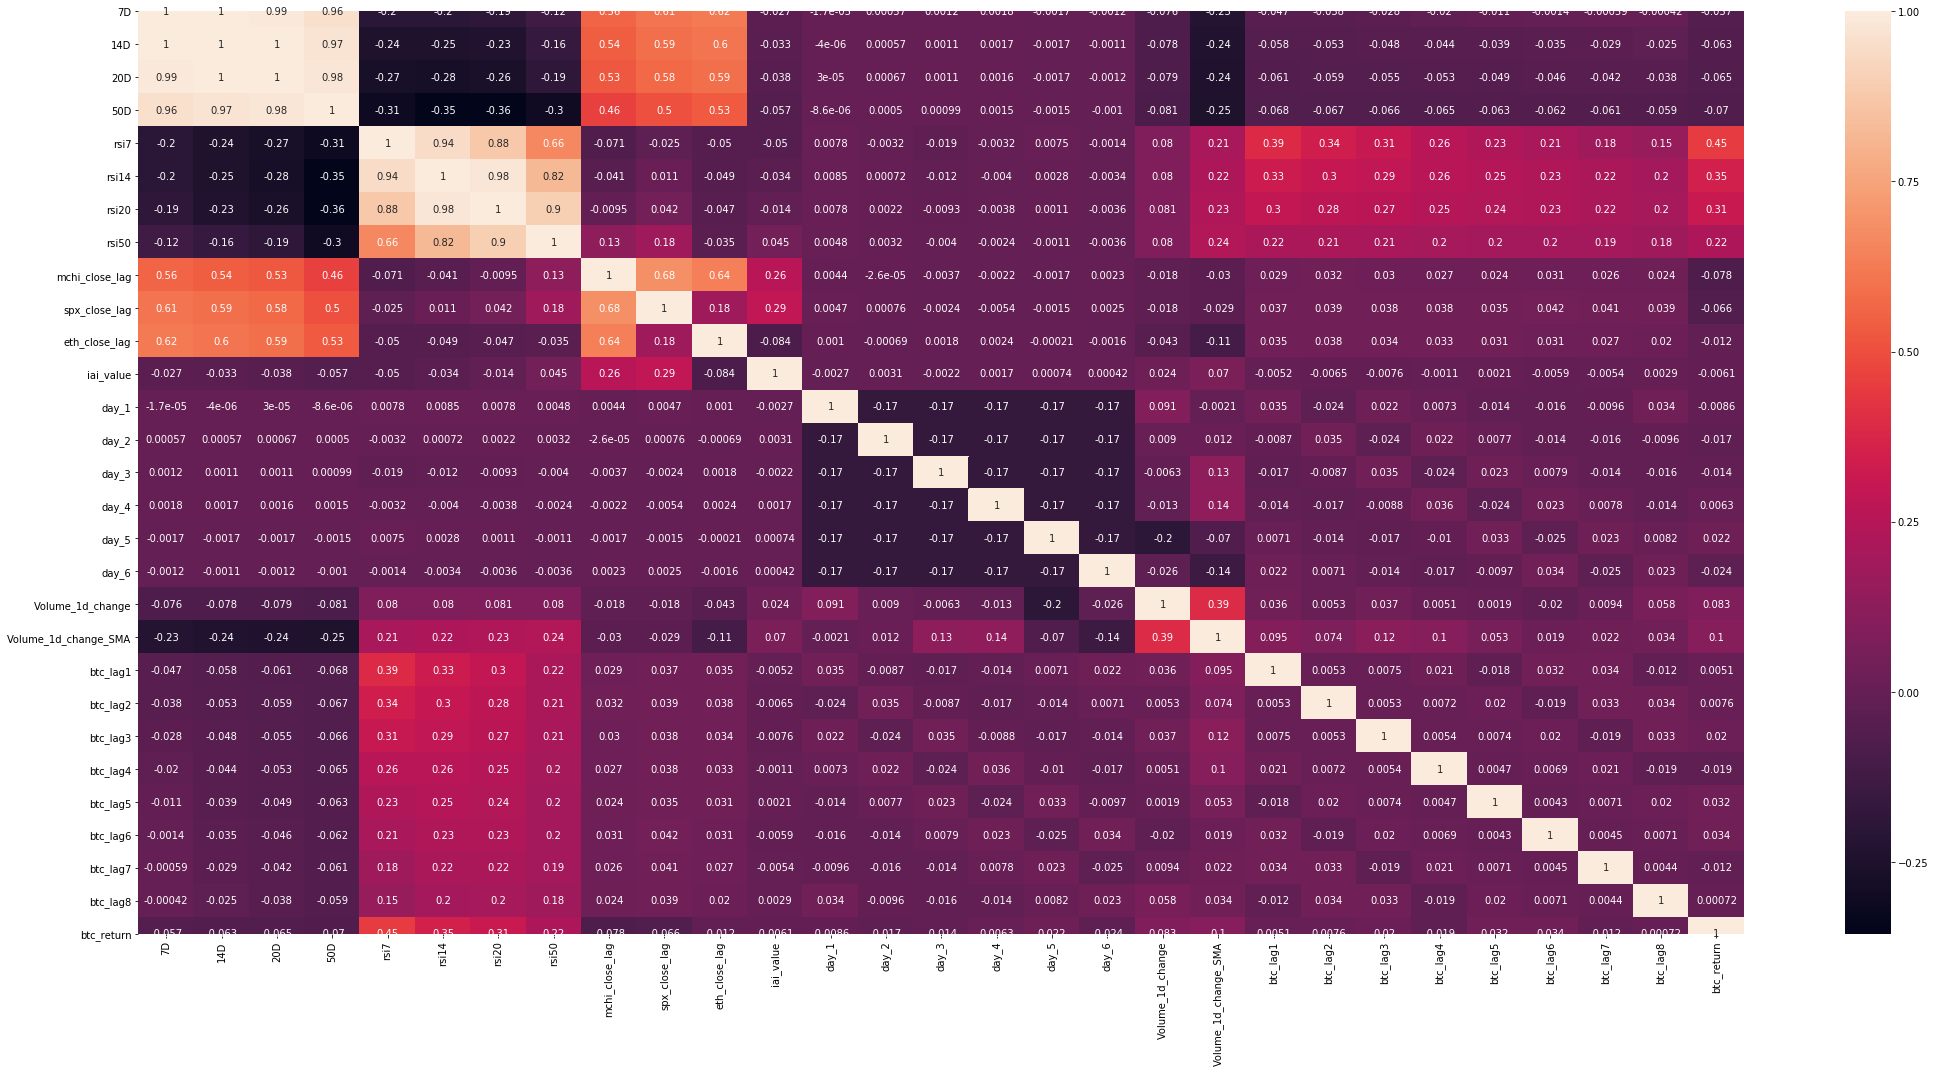

In [47]:
import seaborn as sns
# Plot the correlations between the features and the target
fig, ax = plt.subplots(figsize=(30,15)) 
sns.heatmap(data.corr(), annot=True, ax=ax)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()

## Random Forest Classifier 
### Base model without tuning

In [182]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [67]:
# Setup the Random Forest model and fit training data
rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
predict_train = rf.predict(X_train)

accuracy_score(y_train, predict_train)

0.6845003933910306

### Hyperparameter tuned model

In [181]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [74]:
# Setup the hyperparameter grid
max_depth = [3,4,5,6]
min_samples_leaf = [1,3,5,10]
max_features = ['sqrt','log2']
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features}

# Instantiate a random forest classifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=3, n_estimators=300)

# Instantiate the GridSearchCV object with time series split
tscv = TimeSeriesSplit(n_splits=5)
rfc_cv = GridSearchCV(rfc, param_grid, cv=tscv)

# fit model
rfc_cv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 out of 300 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 2

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 out of 300 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backen

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | ela

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 30

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 out of 300 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 out of 300 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 out of 300 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backen

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300building tree 10 of 300
building tree 11 of 300

building tree 12 of 300building tree 13 of 300

building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300building tree 18 of 300
building tree 19 of 300building tree 20 of 300
building tree 21 of 300

building tree 22 of 300
building tree 23 of 300

building tree 24 of 300
building tree 25 of 300
building tree 26 of 300building tree 27 of 300

building tree 28 of 300
building tree 29 of 300building tree 30 of 300
building tree 31 of 300
building tree 32 of 300

building tree 33 of 300
building tree 34 of 300
building tree 35 of 300building tree 36 of 300

building tree 37 of 300building tree 38 of 300

building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.3s


building tree 124 of 300
building tree 125 of 300
building tree 126 of 300
building tree 127 of 300building tree 128 of 300

building tree 129 of 300
building tree 130 of 300building tree 131 of 300

building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300building tree 137 of 300

building tree 138 of 300
building tree 139 of 300
building tree 140 of 300building tree 141 of 300

building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300building tree 155 of 300

building tree 156 of 300building tree 157 of 300building tree 158 of 300


building tree 159 of 300building tree 160 of 300

building tree 161 of 300
building tree 162 of 300
building tree 163 of 300


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.8s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=300, n_jobs=-1,
                                              oob_score=

In [75]:
rfc_cv.best_params_

{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5}

In [76]:
rfc_cv.best_score_

0.680568720379147

In [77]:
# Setup the Random Forest tuned model and fit test data
rf_tuned = RandomForestClassifier(n_estimators=300, max_depth=6, max_features='sqrt', min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_tuned.fit(X_train, y_train)
predict = rf.predict(X_test)

accuracy_score(y_test, predict)

0.6352201257861635

Text(0.5, 1.0, 'Features Importances')

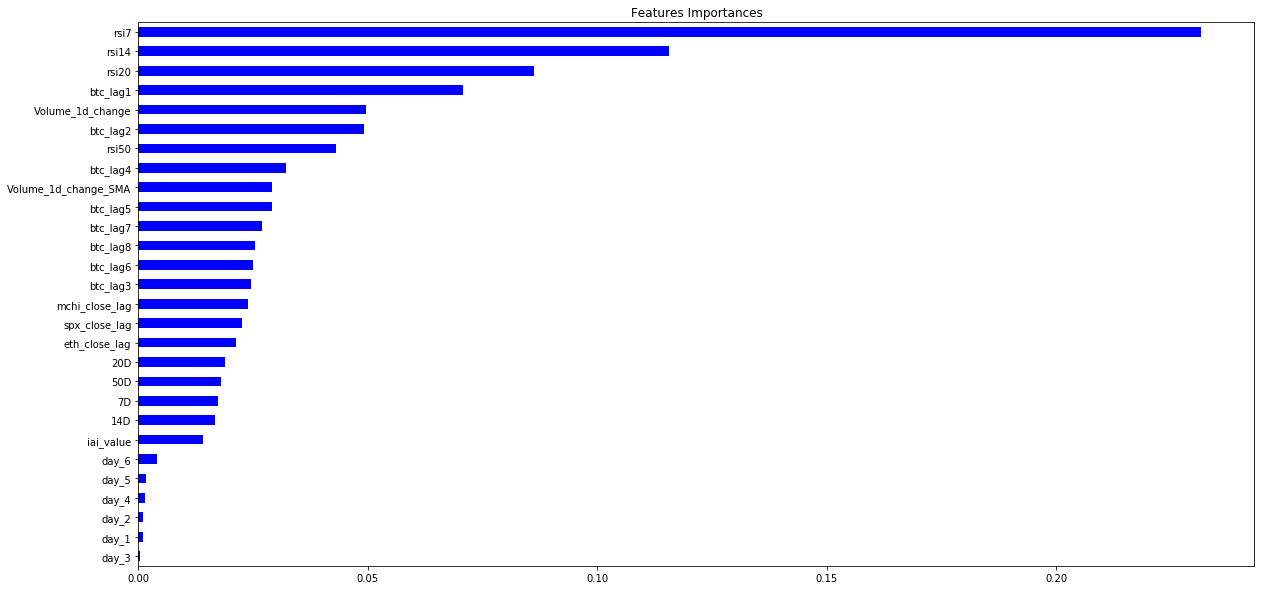

In [81]:
col_names = X_train.columns.tolist()

# Create a pd.Series of features importances
importances = pd.Series(data=rf_tuned.feature_importances_,
                        index= col_names)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(20,10))
importances_sorted.plot(kind='barh', color='blue')
plt.title('Features Importances')

In [82]:
predict

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [93]:
test_period = len(y_test)
prediction = []

for step in range(test_period):
    
    X_data = X[:step - test_period]
    y_data = y[:step - test_period]
    
    # fit model
    mod = RandomForestClassifier(n_estimators=300, max_depth=6, max_features='sqrt', 
                                 min_samples_leaf=5, random_state=42, n_jobs=-1)
    
    # fit mondel on expanding training data
    mod.fit(X_data, y_data)
    
    # predict one-step-ahead
    one_day_forecast = mod.predict(X_test[step: step + 1])
    
    # record one-day-forecast
    prediction.append(one_day_forecast)
    

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\achil\Anaconda3\envs\le

In [139]:
rf_predictions = pd.Series([i[0] for i in prediction],name='rf_predict')
len(rf_predictions)

318

In [149]:
actual_return_btc = df.btc_return[y_test.index]
len(actual_return_btc)

318

In [150]:
rf_compare = pd.DataFrame(actual_return_btc, columns=['btc_return'])

In [142]:
y_test

Date
2019-03-20    1
2019-03-21    0
2019-03-22    0
2019-03-23    1
2019-03-24    0
             ..
2020-01-27    1
2020-01-28    1
2020-01-29    0
2020-01-30    1
2020-01-31    0
Name: btc_return, Length: 318, dtype: int64

In [152]:
rf_compare = rf_compare.reset_index().join(rf_predictions, how='left')

In [154]:
rf_compare.set_index('Date', inplace=True)

In [120]:
# adjusted prediction_quality function (from ARIMA notebook) if statements for binary outcomes of voting classifier

def one_step_results(forecast, observed, btc_returns): #takes three series
    '''takes the model one-step-ahead predictions and simulates a trading strategy.
    Also, generates outcomes for confusion matrix'''
    false_positive = 0 # predicted positive return, actually negative
    false_negative = 0 # predicted negative return, actually positive
    true_positive = 0 # predicted positive return, actually positive
    true_negative = 0 # predicted negative return, actually negative
    returns = []
    
    # Trading Strategy decision algorithm:
    # When return is predicted negative, short BTC (sell) 
    # When return is predicted positive, long BTC (buy/hold)
    for i in forecast.index: 
        if forecast[i] == 1 and observed[i] == 0: # forecast positive, observed negative
            false_positive += 1
            returns.append(btc_returns[i])
        elif forecast[i] == 0 and observed[i] == 1: # forecast negative, observed positive
            false_negative += 1
            returns.append(-btc_returns[i])
        elif forecast[i] == 0 and observed[i] == 0: # forecast negative, observed negative
            true_negative += 1
            returns.append(-btc_returns[i])
        else: # forecast positive, observed positive
            true_positive +=1
            returns.append(btc_returns[i])
            
    returns = pd.Series(returns)
    
    return returns, false_positive, false_negative, true_positive, true_negative

In [156]:
rf_returns, FP, FN, TP, TN = one_step_results(rf_compare.rf_predict, y_test, rf_compare.btc_return)

In [157]:
# create confusion matrix with output from one-step-results function above
positives = [TP, FP]
negatives = [FN, TN]
rows = ['actual positive', 'actual negative']
cols = ['predicted positive', 'predicted negative']

In [158]:
def conf_matrix(positives, negatives, rows, cols):
    df = pd.DataFrame(list(zip(positives, negatives)), index=rows, columns=cols)
    accuracy = round((positives[0] + negatives[1]) / (sum(positives) + sum(negatives)),2)
    return df, accuracy

In [159]:
# tuned random forest model confusion matrix and accuracy for test set
rf_conf_matrix, rf_accuracy = conf_matrix(positives, negatives, rows, cols)
print(f'Random Forest model accuracy score is {rf_accuracy} on test data')
rf_conf_matrix

Random Forest model accuracy score is 0.68 on test data


,predicted positive,predicted negative
actual positive,122,42
actual negative,61,93


In [170]:
rf_returns.name='model_return'

In [173]:
rf_compare = rf_compare.reset_index().join(rf_returns, how='left')

In [176]:
rf_compare.set_index('Date', inplace=True)

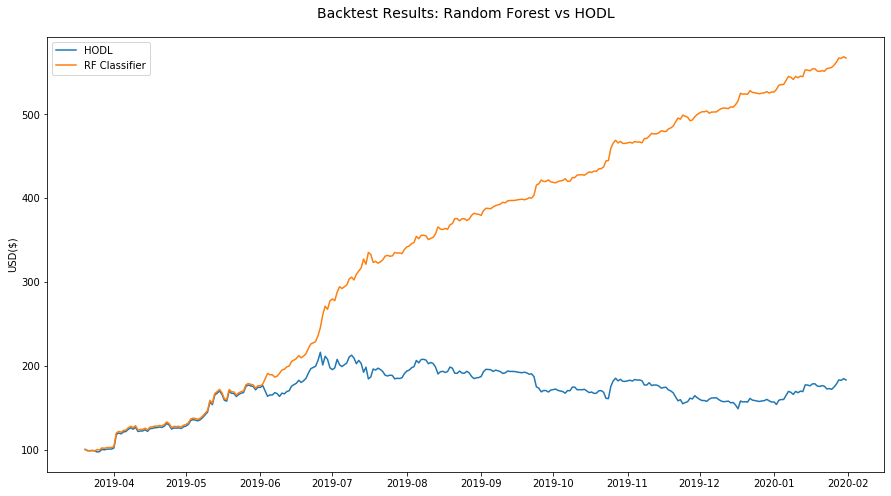

In [177]:
_=plt.figure(figsize=(15,8))
_=plt.title('Backtest Results: Random Forest vs HODL', y=1.03, fontsize=14)
_=plt.ylabel('USD($)')
_=plt.plot(100 * (1 + rf_compare.btc_return.cumsum()), label='HODL')
_=plt.plot(100 * (1 + rf_compare.model_return.cumsum()), label='RF Classifier')        
_=plt.legend()

## Gradient Boosting Classifier
### Base model without tuning

In [178]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [184]:
# Establish baseline GBC with same base assumptions as rf (without pca, without scaling)
gb = GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
gb_predict_train = gb.predict(X_train)

accuracy_score(y_train, predict_train)

0.6845003933910306

### Hyperparameter tuned model

In [186]:
# Setup the pipeline
steps = [('scaler', StandardScaler()), ('pca', PCA()),
        ('gbc', GradientBoostingClassifier(random_state=42, verbose=3, n_estimators=300))]

pipeline = Pipeline(steps)

# Setup the hyperparameter grid
max_depth = [3,4,5,6]
min_samples_leaf = [1,3,5,10]
max_features = ['sqrt','log2']
param_grid = {'gbc__max_depth': max_depth, 'gbc__min_samples_leaf': min_samples_leaf, 'gbc__max_features': max_features}

# Instantiate the GridSearchCV object with time series split
tscv = TimeSeriesSplit(n_splits=5)
gbc_cv = GridSearchCV(pipeline, param_grid, cv=tscv, verbose=3)

# fit model
gbc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] gbc__max_depth=3, gbc__max_features=sqrt, gbc__min_samples_leaf=1 
      Iter       Train Loss   Remaining Time 
         1           1.3390            0.60s
         2           1.2973            0.45s
         3           1.2226            0.39s
         4           1.1737            0.37s
         5           1.1267            0.35s
         6           1.0895            0.34s
         7           1.0394            0.38s
         8           1.0066            0.36s
         9           0.9618            0.39s
        10           0.9381            0.38s
        11           0.9129            0.37s
        12           0.8801            0.38s
        13           0.8578            0.37s
        14           0.8355            0.39s
        15           0.8133            0.38s
        16           0.7945            0.39s
        17           0.7653            0.38s
        18           0.7465            0.39s
        19

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



       111           0.1016            0.25s
       112           0.1003            0.25s
       113           0.0977            0.25s
       114           0.0963            0.25s
       115           0.0948            0.25s
       116           0.0934            0.24s
       117           0.0925            0.24s
       118           0.0906            0.24s
       119           0.0891            0.24s
       120           0.0872            0.24s
       121           0.0861            0.24s
       122           0.0842            0.24s
       123           0.0828            0.24s
       124           0.0810            0.23s
       125           0.0799            0.23s
       126           0.0774            0.23s
       127           0.0754            0.23s
       128           0.0744            0.23s
       129           0.0734            0.23s
       130           0.0723            0.23s
       131           0.0709            0.23s
       132           0.0694            0.23s
       13

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s



       142           0.1978            0.17s
       143           0.1964            0.17s
       144           0.1946            0.17s
       145           0.1933            0.17s
       146           0.1910            0.17s
       147           0.1899            0.17s
       148           0.1882            0.17s
       149           0.1870            0.17s
       150           0.1848            0.17s
       151           0.1829            0.17s
       152           0.1820            0.17s
       153           0.1804            0.16s
       154           0.1792            0.16s
       155           0.1777            0.16s
       156           0.1764            0.16s
       157           0.1743            0.16s
       158           0.1722            0.16s
       159           0.1702            0.16s
       160           0.1684            0.16s
       161           0.1659            0.16s
       162           0.1640            0.16s
       163           0.1629            0.16s
       16

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


         3           1.2408            0.49s
         4           1.2152            0.44s
         5           1.1819            0.47s
         6           1.1695            0.49s
         7           1.1476            0.50s
         8           1.1207            0.51s
         9           1.0918            0.55s
        10           1.0733            0.55s
        11           1.0615            0.52s
        12           1.0392            0.53s
        13           1.0227            0.53s
        14           1.0092            0.51s
        15           0.9887            0.51s
        16           0.9731            0.50s
        17           0.9557            0.50s
        18           0.9408            0.48s
        19           0.9293            0.47s
        20           0.9135            0.47s
        21           0.9027            0.46s
        22           0.8863            0.47s
        23           0.8728            0.46s
        24           0.8603            0.45s
        25

       228           0.1559            0.12s
       229           0.1553            0.12s
       230           0.1543            0.12s
       231           0.1533            0.12s
       232           0.1523            0.11s
       233           0.1512            0.11s
       234           0.1499            0.11s
       235           0.1491            0.11s
       236           0.1481            0.11s
       237           0.1469            0.10s
       238           0.1461            0.10s
       239           0.1449            0.10s
       240           0.1441            0.10s
       241           0.1434            0.10s
       242           0.1422            0.10s
       243           0.1416            0.09s
       244           0.1408            0.09s
       245           0.1397            0.09s
       246           0.1394            0.09s
       247           0.1386            0.09s
       248           0.1374            0.09s
       249           0.1367            0.08s
       250

       142           0.3432            0.30s
       143           0.3424            0.30s
       144           0.3408            0.30s
       145           0.3369            0.30s
       146           0.3341            0.29s
       147           0.3315            0.29s
       148           0.3288            0.29s
       149           0.3260            0.29s
       150           0.3234            0.28s
       151           0.3205            0.28s
       152           0.3180            0.28s
       153           0.3156            0.28s
       154           0.3145            0.28s
       155           0.3121            0.27s
       156           0.3098            0.27s
       157           0.3081            0.27s
       158           0.3060            0.27s
       159           0.3040            0.27s
       160           0.3019            0.26s
       161           0.3006            0.26s
       162           0.2986            0.26s
       163           0.2960            0.26s
       164

        45           0.7228            0.57s
        46           0.7169            0.57s
        47           0.7126            0.56s
        48           0.7063            0.56s
        49           0.7016            0.56s
        50           0.6972            0.56s
        51           0.6906            0.56s
        52           0.6854            0.55s
        53           0.6790            0.55s
        54           0.6749            0.55s
        55           0.6701            0.55s
        56           0.6659            0.55s
        57           0.6618            0.54s
        58           0.6568            0.54s
        59           0.6517            0.54s
        60           0.6463            0.54s
        61           0.6423            0.54s
        62           0.6380            0.53s
        63           0.6337            0.53s
        64           0.6292            0.53s
        65           0.6247            0.52s
        66           0.6194            0.52s
        67

       238           0.2599            0.12s
       239           0.2582            0.12s
       240           0.2571            0.12s
       241           0.2561            0.12s
       242           0.2554            0.12s
       243           0.2543            0.11s
       244           0.2538            0.11s
       245           0.2523            0.11s
       246           0.2515            0.11s
       247           0.2496            0.11s
       248           0.2488            0.10s
       249           0.2477            0.10s
       250           0.2464            0.10s
       251           0.2458            0.10s
       252           0.2444            0.10s
       253           0.2436            0.09s
       254           0.2424            0.09s
       255           0.2416            0.09s
       256           0.2397            0.09s
       257           0.2379            0.09s
       258           0.2373            0.08s
       259           0.2359            0.08s
       260

       266           0.0079            0.03s
       267           0.0077            0.03s
       268           0.0076            0.03s
       269           0.0075            0.03s
       270           0.0074            0.03s
       271           0.0073            0.03s
       272           0.0072            0.03s
       273           0.0071            0.02s
       274           0.0069            0.02s
       275           0.0069            0.02s
       276           0.0068            0.02s
       277           0.0066            0.02s
       278           0.0066            0.02s
       279           0.0065            0.02s
       280           0.0063            0.02s
       281           0.0062            0.02s
       282           0.0061            0.02s
       283           0.0060            0.02s
       284           0.0058            0.01s
       285           0.0057            0.01s
       286           0.0056            0.01s
       287           0.0055            0.01s
       288

      Iter       Train Loss   Remaining Time 
         1           1.3129            0.60s
         2           1.2712            0.45s
         3           1.2415            0.40s
         4           1.2159            0.45s
         5           1.1827            0.41s
         6           1.1709            0.39s
         7           1.1497            0.42s
         8           1.1238            0.40s
         9           1.0948            0.39s
        10           1.0786            0.40s
        11           1.0680            0.42s
        12           1.0449            0.45s
        13           1.0278            0.46s
        14           1.0107            0.47s
        15           0.9897            0.49s
        16           0.9733            0.50s
        17           0.9592            0.50s
        18           0.9424            0.48s
        19           0.9336            0.49s
        20           0.9162            0.47s
        21           0.9033            0.48s
        2

       202           0.1911            0.18s
       203           0.1903            0.18s
       204           0.1886            0.18s
       205           0.1865            0.18s
       206           0.1852            0.17s
       207           0.1835            0.17s
       208           0.1827            0.17s
       209           0.1820            0.17s
       210           0.1802            0.17s
       211           0.1792            0.17s
       212           0.1773            0.16s
       213           0.1763            0.16s
       214           0.1751            0.16s
       215           0.1735            0.16s
       216           0.1720            0.16s
       217           0.1712            0.16s
       218           0.1697            0.15s
       219           0.1690            0.15s
       220           0.1686            0.15s
       221           0.1666            0.15s
       222           0.1660            0.15s
       223           0.1648            0.15s
       224

        81           0.5104            0.52s
        82           0.5060            0.51s
        83           0.5030            0.51s
        84           0.5004            0.51s
        85           0.4970            0.51s
        86           0.4945            0.50s
        87           0.4918            0.50s
        88           0.4899            0.50s
        89           0.4857            0.49s
        90           0.4817            0.49s
        91           0.4771            0.49s
        92           0.4740            0.48s
        93           0.4708            0.48s
        94           0.4658            0.47s
        95           0.4617            0.47s
        96           0.4584            0.47s
        97           0.4542            0.46s
        98           0.4501            0.46s
        99           0.4470            0.46s
       100           0.4429            0.45s
       101           0.4400            0.45s
       102           0.4383            0.45s
       103

         6           1.1710            0.59s
         7           1.1516            0.63s
         8           1.1337            0.66s
         9           1.1063            0.64s
        10           1.0824            0.64s
        11           1.0744            0.66s
        12           1.0545            0.67s
        13           1.0440            0.66s
        14           1.0302            0.65s
        15           1.0166            0.65s
        16           1.0023            0.64s
        17           0.9885            0.63s
        18           0.9691            0.61s
        19           0.9561            0.61s
        20           0.9442            0.60s
        21           0.9359            0.61s
        22           0.9208            0.60s
        23           0.9069            0.60s
        24           0.9003            0.60s
        25           0.8875            0.59s
        26           0.8799            0.58s
        27           0.8687            0.57s
        28

       192           0.3061            0.22s
       193           0.3045            0.21s
       194           0.3028            0.21s
       195           0.3009            0.21s
       196           0.2995            0.21s
       197           0.2978            0.21s
       198           0.2962            0.20s
       199           0.2942            0.20s
       200           0.2924            0.20s
       201           0.2912            0.20s
       202           0.2896            0.20s
       203           0.2879            0.19s
       204           0.2863            0.19s
       205           0.2858            0.19s
       206           0.2843            0.19s
       207           0.2829            0.19s
       208           0.2812            0.18s
       209           0.2798            0.18s
       210           0.2776            0.18s
       211           0.2768            0.18s
       212           0.2761            0.18s
       213           0.2747            0.17s
       214

       155           0.0525            0.14s
       156           0.0514            0.14s
       157           0.0502            0.14s
       158           0.0494            0.14s
       159           0.0488            0.14s
       160           0.0485            0.14s
       161           0.0481            0.13s
       162           0.0474            0.13s
       163           0.0466            0.13s
       164           0.0460            0.13s
       165           0.0453            0.13s
       166           0.0447            0.13s
       167           0.0441            0.13s
       168           0.0434            0.13s
       169           0.0430            0.13s
       170           0.0422            0.13s
       171           0.0411            0.12s
       172           0.0402            0.12s
       173           0.0394            0.12s
       174           0.0386            0.12s
       175           0.0378            0.12s
       176           0.0371            0.12s
       177

        47           0.5837            0.30s
        48           0.5747            0.30s
        49           0.5694            0.31s
        50           0.5633            0.31s
        51           0.5558            0.31s
        52           0.5478            0.31s
        53           0.5413            0.31s
        54           0.5361            0.31s
        55           0.5293            0.31s
        56           0.5217            0.31s
        57           0.5153            0.31s
        58           0.5085            0.31s
        59           0.5003            0.31s
        60           0.4916            0.31s
        61           0.4857            0.30s
        62           0.4768            0.30s
        63           0.4697            0.30s
        64           0.4633            0.30s
        65           0.4565            0.30s
        66           0.4502            0.30s
        67           0.4438            0.29s
        68           0.4403            0.30s
        69

        58           0.5800            0.32s
        59           0.5759            0.33s
        60           0.5698            0.33s
        61           0.5649            0.33s
        62           0.5589            0.33s
        63           0.5530            0.32s
        64           0.5469            0.32s
        65           0.5421            0.32s
        66           0.5380            0.32s
        67           0.5328            0.32s
        68           0.5299            0.32s
        69           0.5272            0.32s
        70           0.5212            0.31s
        71           0.5160            0.32s
        72           0.5102            0.32s
        73           0.5047            0.31s
        74           0.5007            0.31s
        75           0.4967            0.31s
        76           0.4932            0.31s
        77           0.4877            0.31s
        78           0.4815            0.31s
        79           0.4771            0.31s
        80

        24           0.8636            0.42s
        25           0.8515            0.45s
        26           0.8419            0.47s
        27           0.8306            0.48s
        28           0.8206            0.49s
        29           0.8107            0.50s
        30           0.7992            0.51s
        31           0.7883            0.52s
        32           0.7812            0.53s
        33           0.7742            0.53s
        34           0.7633            0.54s
        35           0.7542            0.54s
        36           0.7455            0.54s
        37           0.7388            0.54s
        38           0.7326            0.53s
        39           0.7262            0.53s
        40           0.7189            0.53s
        41           0.7131            0.52s
        42           0.7055            0.51s
        43           0.6986            0.51s
        44           0.6919            0.51s
        45           0.6863            0.51s
        46

       252           0.1712            0.08s
       253           0.1700            0.08s
       254           0.1688            0.08s
       255           0.1678            0.07s
       256           0.1666            0.07s
       257           0.1657            0.07s
       258           0.1648            0.07s
       259           0.1642            0.07s
       260           0.1632            0.07s
       261           0.1623            0.06s
       262           0.1612            0.06s
       263           0.1603            0.06s
       264           0.1592            0.06s
       265           0.1586            0.06s
       266           0.1581            0.06s
       267           0.1573            0.05s
       268           0.1566            0.05s
       269           0.1557            0.05s
       270           0.1550            0.05s
       271           0.1539            0.05s
       272           0.1525            0.05s
       273           0.1519            0.04s
       274

       138           0.4127            0.35s
       139           0.4117            0.34s
       140           0.4105            0.34s
       141           0.4084            0.34s
       142           0.4065            0.34s
       143           0.4042            0.34s
       144           0.4024            0.34s
       145           0.3992            0.34s
       146           0.3966            0.33s
       147           0.3952            0.33s
       148           0.3931            0.33s
       149           0.3912            0.33s
       150           0.3899            0.32s
       151           0.3877            0.32s
       152           0.3854            0.32s
       153           0.3827            0.32s
       154           0.3809            0.31s
       155           0.3791            0.31s
       156           0.3772            0.31s
       157           0.3747            0.31s
       158           0.3733            0.30s
       159           0.3713            0.30s
       160

        69           0.2882            0.18s
        70           0.2824            0.18s
        71           0.2764            0.18s
        72           0.2706            0.18s
        73           0.2662            0.18s
        74           0.2635            0.18s
        75           0.2597            0.18s
        76           0.2566            0.18s
        77           0.2528            0.18s
        78           0.2484            0.18s
        79           0.2445            0.18s
        80           0.2388            0.18s
        81           0.2338            0.18s
        82           0.2282            0.18s
        83           0.2241            0.18s
        84           0.2205            0.18s
        85           0.2164            0.18s
        86           0.2108            0.18s
        87           0.2067            0.18s
        88           0.2021            0.18s
        89           0.1997            0.17s
        90           0.1963            0.18s
        91

       283           0.0101            0.01s
       284           0.0099            0.01s
       285           0.0098            0.01s
       286           0.0096            0.01s
       287           0.0096            0.01s
       288           0.0094            0.01s
       289           0.0093            0.01s
       290           0.0091            0.01s
       291           0.0090            0.01s
       292           0.0089            0.01s
       293           0.0088            0.01s
       294           0.0087            0.01s
       295           0.0086            0.00s
       296           0.0084            0.00s
       297           0.0083            0.00s
       298           0.0081            0.00s
       299           0.0080            0.00s
       300           0.0078            0.00s
[CV]  gbc__max_depth=3, gbc__max_features=sqrt, gbc__min_samples_leaf=10, score=0.559, total=   0.3s
[CV] gbc__max_depth=3, gbc__max_features=sqrt, gbc__min_samples_leaf=10 
      Iter      

        13           1.0324            0.57s
        14           1.0153            0.59s
        15           0.9944            0.57s
        16           0.9761            0.57s
        17           0.9588            0.55s
        18           0.9431            0.55s
        19           0.9343            0.55s
        20           0.9180            0.54s
        21           0.9049            0.54s
        22           0.8906            0.54s
        23           0.8754            0.54s
        24           0.8627            0.53s
        25           0.8496            0.52s
        26           0.8379            0.51s
        27           0.8248            0.51s
        28           0.8144            0.51s
        29           0.8016            0.52s
        30           0.7942            0.52s
        31           0.7834            0.51s
        32           0.7755            0.50s
        33           0.7652            0.49s
        34           0.7564            0.49s
        35

       265           0.1229            0.05s
       266           0.1222            0.05s
       267           0.1210            0.05s
       268           0.1200            0.05s
       269           0.1190            0.05s
       270           0.1184            0.05s
       271           0.1175            0.04s
       272           0.1162            0.04s
       273           0.1152            0.04s
       274           0.1142            0.04s
       275           0.1134            0.04s
       276           0.1124            0.04s
       277           0.1115            0.03s
       278           0.1108            0.03s
       279           0.1099            0.03s
       280           0.1090            0.03s
       281           0.1082            0.03s
       282           0.1075            0.03s
       283           0.1068            0.03s
       284           0.1060            0.02s
       285           0.1050            0.02s
       286           0.1043            0.02s
       287

       150           0.3328            0.32s
       151           0.3308            0.32s
       152           0.3284            0.32s
       153           0.3260            0.31s
       154           0.3237            0.31s
       155           0.3218            0.31s
       156           0.3203            0.31s
       157           0.3182            0.30s
       158           0.3170            0.30s
       159           0.3151            0.30s
       160           0.3127            0.30s
       161           0.3115            0.29s
       162           0.3091            0.29s
       163           0.3072            0.29s
       164           0.3056            0.29s
       165           0.3038            0.28s
       166           0.3014            0.28s
       167           0.2998            0.28s
       168           0.2976            0.28s
       169           0.2964            0.28s
       170           0.2943            0.27s
       171           0.2923            0.27s
       172

        51           0.6995            0.60s
        52           0.6967            0.60s
        53           0.6895            0.60s
        54           0.6848            0.60s
        55           0.6814            0.60s
        56           0.6760            0.60s
        57           0.6715            0.60s
        58           0.6661            0.59s
        59           0.6623            0.59s
        60           0.6578            0.59s
        61           0.6541            0.58s
        62           0.6502            0.58s
        63           0.6452            0.57s
        64           0.6411            0.58s
        65           0.6364            0.58s
        66           0.6310            0.58s
        67           0.6261            0.58s
        68           0.6217            0.58s
        69           0.6178            0.58s
        70           0.6115            0.58s
        71           0.6081            0.58s
        72           0.6043            0.58s
        73

        53           0.3560            0.20s
        54           0.3494            0.20s
        55           0.3420            0.20s
        56           0.3341            0.20s
        57           0.3275            0.20s
        58           0.3190            0.20s
        59           0.3095            0.20s
        60           0.3051            0.20s
        61           0.3011            0.19s
        62           0.2941            0.19s
        63           0.2901            0.19s
        64           0.2842            0.19s
        65           0.2785            0.19s
        66           0.2742            0.19s
        67           0.2688            0.19s
        68           0.2646            0.19s
        69           0.2583            0.19s
        70           0.2544            0.18s
        71           0.2503            0.18s
        72           0.2455            0.18s
        73           0.2409            0.18s
        74           0.2374            0.18s
        75

       282           0.0082            0.01s
       283           0.0081            0.01s
       284           0.0079            0.01s
       285           0.0079            0.01s
       286           0.0077            0.01s
       287           0.0076            0.01s
       288           0.0075            0.01s
       289           0.0074            0.01s
       290           0.0073            0.01s
       291           0.0071            0.01s
       292           0.0070            0.01s
       293           0.0069            0.01s
       294           0.0068            0.00s
       295           0.0067            0.00s
       296           0.0066            0.00s
       297           0.0064            0.00s
       298           0.0063            0.00s
       299           0.0062            0.00s
       300           0.0061            0.00s
[CV]  gbc__max_depth=3, gbc__max_features=log2, gbc__min_samples_leaf=1, score=0.607, total=   0.3s
[CV] gbc__max_depth=3, gbc__max_features=log2

        27           0.8360            0.35s
        28           0.8258            0.37s
        29           0.8136            0.37s
        30           0.8062            0.38s
        31           0.7939            0.38s
        32           0.7824            0.38s
        33           0.7709            0.39s
        34           0.7613            0.38s
        35           0.7526            0.39s
        36           0.7433            0.38s
        37           0.7317            0.38s
        38           0.7228            0.37s
        39           0.7161            0.37s
        40           0.7076            0.37s
        41           0.6996            0.37s
        42           0.6900            0.36s
        43           0.6825            0.36s
        44           0.6759            0.37s
        45           0.6670            0.37s
        46           0.6583            0.36s
        47           0.6522            0.36s
        48           0.6442            0.36s
        49

        11           1.0608            0.42s
        12           1.0362            0.43s
        13           1.0271            0.44s
        14           1.0107            0.47s
        15           0.9936            0.47s
        16           0.9748            0.48s
        17           0.9613            0.48s
        18           0.9472            0.48s
        19           0.9329            0.50s
        20           0.9184            0.50s
        21           0.9029            0.50s
        22           0.8872            0.50s
        23           0.8764            0.50s
        24           0.8661            0.49s
        25           0.8548            0.48s
        26           0.8470            0.48s
        27           0.8363            0.47s
        28           0.8267            0.47s
        29           0.8178            0.47s
        30           0.8084            0.46s
        31           0.7982            0.47s
        32           0.7880            0.47s
        33

       261           0.1679            0.06s
       262           0.1666            0.06s
       263           0.1652            0.06s
       264           0.1640            0.05s
       265           0.1629            0.05s
       266           0.1622            0.05s
       267           0.1612            0.05s
       268           0.1600            0.05s
       269           0.1597            0.05s
       270           0.1583            0.04s
       271           0.1575            0.04s
       272           0.1570            0.04s
       273           0.1563            0.04s
       274           0.1560            0.04s
       275           0.1550            0.04s
       276           0.1546            0.04s
       277           0.1540            0.03s
       278           0.1534            0.03s
       279           0.1527            0.03s
       280           0.1522            0.03s
       281           0.1510            0.03s
       282           0.1503            0.03s
       283

       173           0.3672            0.23s
       174           0.3656            0.23s
       175           0.3640            0.23s
       176           0.3622            0.22s
       177           0.3610            0.22s
       178           0.3598            0.22s
       179           0.3587            0.22s
       180           0.3563            0.22s
       181           0.3537            0.22s
       182           0.3505            0.21s
       183           0.3496            0.21s
       184           0.3478            0.21s
       185           0.3457            0.21s
       186           0.3436            0.21s
       187           0.3421            0.20s
       188           0.3405            0.20s
       189           0.3396            0.20s
       190           0.3373            0.20s
       191           0.3347            0.20s
       192           0.3328            0.19s
       193           0.3315            0.19s
       194           0.3295            0.19s
       195

       188           0.0345            0.10s
       189           0.0341            0.10s
       190           0.0336            0.09s
       191           0.0332            0.09s
       192           0.0326            0.09s
       193           0.0318            0.09s
       194           0.0312            0.09s
       195           0.0309            0.09s
       196           0.0305            0.09s
       197           0.0302            0.09s
       198           0.0295            0.09s
       199           0.0291            0.09s
       200           0.0288            0.09s
       201           0.0283            0.09s
       202           0.0278            0.09s
       203           0.0275            0.08s
       204           0.0271            0.08s
       205           0.0268            0.08s
       206           0.0263            0.08s
       207           0.0256            0.08s
       208           0.0252            0.08s
       209           0.0248            0.08s
       210

        88           0.3713            0.20s
        89           0.3680            0.20s
        90           0.3643            0.20s
        91           0.3607            0.20s
        92           0.3566            0.20s
        93           0.3522            0.20s
        94           0.3486            0.20s
        95           0.3451            0.20s
        96           0.3410            0.20s
        97           0.3366            0.20s
        98           0.3308            0.20s
        99           0.3275            0.20s
       100           0.3234            0.20s
       101           0.3212            0.20s
       102           0.3176            0.20s
       103           0.3143            0.20s
       104           0.3105            0.20s
       105           0.3072            0.19s
       106           0.3033            0.19s
       107           0.3000            0.19s
       108           0.2975            0.19s
       109           0.2955            0.19s
       110

       102           0.4104            0.28s
       103           0.4082            0.28s
       104           0.4072            0.28s
       105           0.4036            0.28s
       106           0.4001            0.28s
       107           0.3970            0.28s
       108           0.3952            0.28s
       109           0.3936            0.28s
       110           0.3902            0.28s
       111           0.3879            0.28s
       112           0.3835            0.28s
       113           0.3793            0.28s
       114           0.3757            0.28s
       115           0.3734            0.28s
       116           0.3724            0.28s
       117           0.3714            0.28s
       118           0.3690            0.28s
       119           0.3661            0.27s
       120           0.3646            0.27s
       121           0.3625            0.27s
       122           0.3598            0.27s
       123           0.3557            0.27s
       124

        79           0.5249            0.32s
        80           0.5216            0.32s
        81           0.5180            0.32s
        82           0.5147            0.32s
        83           0.5110            0.32s
        84           0.5070            0.32s
        85           0.5037            0.32s
        86           0.4993            0.32s
        87           0.4954            0.32s
        88           0.4919            0.32s
        89           0.4884            0.32s
        90           0.4849            0.32s
        91           0.4825            0.32s
        92           0.4789            0.32s
        93           0.4760            0.32s
        94           0.4718            0.32s
        95           0.4683            0.32s
        96           0.4651            0.31s
        97           0.4617            0.31s
        98           0.4580            0.31s
        99           0.4564            0.31s
       100           0.4534            0.31s
       101

        29           0.9064            0.50s
        30           0.8985            0.50s
        31           0.8871            0.50s
        32           0.8814            0.51s
        33           0.8718            0.52s
        34           0.8596            0.51s
        35           0.8544            0.52s
        36           0.8452            0.53s
        37           0.8343            0.53s
        38           0.8260            0.53s
        39           0.8188            0.52s
        40           0.8110            0.52s
        41           0.8012            0.51s
        42           0.7898            0.51s
        43           0.7824            0.51s
        44           0.7782            0.50s
        45           0.7703            0.50s
        46           0.7621            0.49s
        47           0.7592            0.49s
        48           0.7521            0.48s
        49           0.7489            0.48s
        50           0.7408            0.48s
        51

       235           0.2726            0.12s
       236           0.2709            0.12s
       237           0.2693            0.11s
       238           0.2673            0.11s
       239           0.2661            0.11s
       240           0.2648            0.11s
       241           0.2634            0.11s
       242           0.2627            0.11s
       243           0.2616            0.10s
       244           0.2607            0.10s
       245           0.2588            0.10s
       246           0.2578            0.10s
       247           0.2566            0.10s
       248           0.2555            0.09s
       249           0.2549            0.09s
       250           0.2534            0.09s
       251           0.2526            0.09s
       252           0.2512            0.09s
       253           0.2496            0.09s
       254           0.2484            0.08s
       255           0.2471            0.08s
       256           0.2456            0.08s
       257

         7           1.1582            0.25s
         8           1.1310            0.29s
         9           1.1019            0.29s
        10           1.0788            0.29s
        11           1.0631            0.31s
        12           1.0413            0.31s
        13           1.0238            0.33s
        14           1.0079            0.33s
        15           0.9911            0.32s
        16           0.9742            0.34s
        17           0.9549            0.33s
        18           0.9352            0.33s
        19           0.9154            0.32s
        20           0.9026            0.32s
        21           0.8887            0.32s
        22           0.8762            0.32s
        23           0.8634            0.30s
        24           0.8537            0.30s
        25           0.8393            0.30s
        26           0.8224            0.29s
        27           0.8103            0.29s
        28           0.7969            0.29s
        29

        59           0.5937            0.29s
        60           0.5899            0.29s
        61           0.5845            0.29s
        62           0.5785            0.28s
        63           0.5738            0.29s
        64           0.5657            0.28s
        65           0.5593            0.28s
        66           0.5536            0.28s
        67           0.5480            0.28s
        68           0.5443            0.28s
        69           0.5392            0.28s
        70           0.5343            0.28s
        71           0.5288            0.28s
        72           0.5241            0.28s
        73           0.5217            0.28s
        74           0.5172            0.28s
        75           0.5129            0.28s
        76           0.5087            0.28s
        77           0.5038            0.28s
        78           0.4984            0.28s
        79           0.4941            0.28s
        80           0.4899            0.27s
        81

        45           0.6976            0.36s
        46           0.6892            0.36s
        47           0.6839            0.36s
        48           0.6774            0.36s
        49           0.6714            0.36s
        50           0.6651            0.35s
        51           0.6587            0.36s
        52           0.6552            0.35s
        53           0.6494            0.35s
        54           0.6417            0.35s
        55           0.6361            0.35s
        56           0.6307            0.35s
        57           0.6251            0.35s
        58           0.6189            0.35s
        59           0.6150            0.34s
        60           0.6111            0.34s
        61           0.6058            0.34s
        62           0.6006            0.34s
        63           0.5959            0.34s
        64           0.5910            0.34s
        65           0.5856            0.34s
        66           0.5795            0.34s
        67

         2           1.2810            0.59s
         3           1.2520            0.69s
         4           1.2223            0.66s
         5           1.2069            0.65s
         6           1.1909            0.59s
         7           1.1701            0.58s
         8           1.1588            0.58s
         9           1.1314            0.58s
        10           1.1112            0.58s
        11           1.1053            0.58s
        12           1.0857            0.60s
        13           1.0805            0.59s
        14           1.0637            0.59s
        15           1.0556            0.57s
        16           1.0438            0.57s
        17           1.0292            0.56s
        18           1.0046            0.55s
        19           0.9927            0.55s
        20           0.9817            0.53s
        21           0.9754            0.53s
        22           0.9555            0.53s
        23           0.9452            0.54s
        24

       228           0.2814            0.12s
       229           0.2798            0.12s
       230           0.2777            0.12s
       231           0.2764            0.12s
       232           0.2753            0.11s
       233           0.2743            0.11s
       234           0.2732            0.11s
       235           0.2720            0.11s
       236           0.2703            0.11s
       237           0.2687            0.11s
       238           0.2671            0.10s
       239           0.2656            0.10s
       240           0.2650            0.10s
       241           0.2642            0.10s
       242           0.2629            0.10s
       243           0.2619            0.10s
       244           0.2608            0.09s
       245           0.2601            0.09s
       246           0.2586            0.09s
       247           0.2568            0.09s
       248           0.2559            0.09s
       249           0.2551            0.09s
       250

       287           0.0122            0.01s
       288           0.0121            0.01s
       289           0.0119            0.01s
       290           0.0118            0.01s
       291           0.0116            0.01s
       292           0.0115            0.01s
       293           0.0112            0.01s
       294           0.0111            0.01s
       295           0.0109            0.00s
       296           0.0106            0.00s
       297           0.0104            0.00s
       298           0.0102            0.00s
       299           0.0100            0.00s
       300           0.0099            0.00s
[CV]  gbc__max_depth=3, gbc__max_features=log2, gbc__min_samples_leaf=10, score=0.607, total=   0.3s
[CV] gbc__max_depth=3, gbc__max_features=log2, gbc__min_samples_leaf=10 
      Iter       Train Loss   Remaining Time 
         1           1.3336            0.30s
         2           1.3082            0.30s
         3           1.2659            0.30s
         4     

        30           0.8249            0.38s
        31           0.8150            0.38s
        32           0.8015            0.38s
        33           0.7884            0.39s
        34           0.7779            0.39s
        35           0.7702            0.39s
        36           0.7644            0.39s
        37           0.7549            0.39s
        38           0.7472            0.39s
        39           0.7397            0.39s
        40           0.7317            0.38s
        41           0.7231            0.38s
        42           0.7137            0.38s
        43           0.7037            0.38s
        44           0.6966            0.38s
        45           0.6872            0.37s
        46           0.6792            0.37s
        47           0.6751            0.37s
        48           0.6663            0.37s
        49           0.6623            0.36s
        50           0.6576            0.36s
        51           0.6489            0.36s
        52

        24           0.8819            0.38s
        25           0.8721            0.38s
        26           0.8620            0.39s
        27           0.8508            0.39s
        28           0.8404            0.40s
        29           0.8323            0.39s
        30           0.8225            0.39s
        31           0.8146            0.39s
        32           0.8044            0.39s
        33           0.7967            0.39s
        34           0.7873            0.39s
        35           0.7807            0.39s
        36           0.7710            0.39s
        37           0.7651            0.38s
        38           0.7599            0.39s
        39           0.7524            0.39s
        40           0.7453            0.39s
        41           0.7376            0.38s
        42           0.7307            0.39s
        43           0.7234            0.38s
        44           0.7165            0.38s
        45           0.7092            0.38s
        46

       287           0.1625            0.02s
       288           0.1613            0.02s
       289           0.1601            0.02s
       290           0.1594            0.01s
       291           0.1587            0.01s
       292           0.1578            0.01s
       293           0.1566            0.01s
       294           0.1560            0.01s
       295           0.1549            0.01s
       296           0.1546            0.01s
       297           0.1541            0.00s
       298           0.1531            0.00s
       299           0.1523            0.00s
       300           0.1519            0.00s
[CV]  gbc__max_depth=3, gbc__max_features=log2, gbc__min_samples_leaf=10, score=0.725, total=   0.4s
[CV] gbc__max_depth=3, gbc__max_features=log2, gbc__min_samples_leaf=10 
      Iter       Train Loss   Remaining Time 
         1           1.3140            0.89s
         2           1.2810            0.75s
         3           1.2520            0.79s
         4     

       190           0.3345            0.20s
       191           0.3332            0.20s
       192           0.3318            0.20s
       193           0.3307            0.20s
       194           0.3293            0.19s
       195           0.3270            0.19s
       196           0.3253            0.19s
       197           0.3239            0.19s
       198           0.3228            0.19s
       199           0.3208            0.18s
       200           0.3188            0.18s
       201           0.3165            0.18s
       202           0.3143            0.18s
       203           0.3131            0.18s
       204           0.3122            0.18s
       205           0.3108            0.17s
       206           0.3092            0.17s
       207           0.3074            0.17s
       208           0.3057            0.17s
       209           0.3046            0.17s
       210           0.3038            0.16s
       211           0.3021            0.16s
       212

       156           0.0085            0.17s
       157           0.0083            0.17s
       158           0.0081            0.17s
       159           0.0079            0.17s
       160           0.0077            0.17s
       161           0.0075            0.17s
       162           0.0073            0.16s
       163           0.0072            0.16s
       164           0.0069            0.16s
       165           0.0068            0.16s
       166           0.0067            0.16s
       167           0.0065            0.16s
       168           0.0063            0.16s
       169           0.0061            0.16s
       170           0.0060            0.15s
       171           0.0058            0.15s
       172           0.0056            0.15s
       173           0.0054            0.15s
       174           0.0052            0.15s
       175           0.0050            0.15s
       176           0.0049            0.15s
       177           0.0047            0.15s
       178

        36           0.4636            0.39s
        37           0.4491            0.40s
        38           0.4428            0.39s
        39           0.4331            0.39s
        40           0.4225            0.40s
        41           0.4136            0.40s
        42           0.4034            0.40s
        43           0.3933            0.41s
        44           0.3863            0.41s
        45           0.3769            0.41s
        46           0.3712            0.40s
        47           0.3654            0.40s
        48           0.3559            0.40s
        49           0.3459            0.40s
        50           0.3401            0.40s
        51           0.3330            0.39s
        52           0.3234            0.39s
        53           0.3151            0.39s
        54           0.3078            0.39s
        55           0.3017            0.39s
        56           0.2941            0.39s
        57           0.2899            0.39s
        58

         1           1.2981            0.89s
         2           1.2385            0.90s
         3           1.1983            0.89s
         4           1.1509            0.81s
         5           1.1141            0.76s
         6           1.0925            0.73s
         7           1.0636            0.71s
         8           1.0320            0.69s
         9           0.9945            0.71s
        10           0.9694            0.69s
        11           0.9449            0.68s
        12           0.9165            0.65s
        13           0.8979            0.64s
        14           0.8700            0.63s
        15           0.8460            0.63s
        16           0.8231            0.62s
        17           0.8001            0.61s
        18           0.7759            0.59s
        19           0.7571            0.59s
        20           0.7353            0.57s
        21           0.7222            0.57s
        22           0.7045            0.57s
        23

       211           0.0395            0.16s
       212           0.0388            0.16s
       213           0.0383            0.16s
       214           0.0380            0.15s
       215           0.0372            0.15s
       216           0.0366            0.15s
       217           0.0360            0.15s
       218           0.0354            0.15s
       219           0.0351            0.14s
       220           0.0346            0.14s
       221           0.0342            0.14s
       222           0.0339            0.14s
       223           0.0333            0.14s
       224           0.0329            0.14s
       225           0.0324            0.13s
       226           0.0319            0.13s
       227           0.0316            0.13s
       228           0.0312            0.13s
       229           0.0308            0.13s
       230           0.0303            0.12s
       231           0.0298            0.12s
       232           0.0294            0.12s
       233

        97           0.2348            0.46s
        98           0.2314            0.46s
        99           0.2286            0.46s
       100           0.2264            0.46s
       101           0.2238            0.46s
       102           0.2213            0.45s
       103           0.2188            0.45s
       104           0.2167            0.45s
       105           0.2137            0.45s
       106           0.2113            0.44s
       107           0.2094            0.44s
       108           0.2064            0.44s
       109           0.2044            0.43s
       110           0.2021            0.43s
       111           0.2009            0.43s
       112           0.1987            0.42s
       113           0.1965            0.42s
       114           0.1951            0.42s
       115           0.1932            0.42s
       116           0.1908            0.41s
       117           0.1887            0.41s
       118           0.1870            0.41s
       119

       284           0.0304            0.03s
       285           0.0302            0.03s
       286           0.0300            0.03s
       287           0.0295            0.03s
       288           0.0291            0.03s
       289           0.0287            0.02s
       290           0.0284            0.02s
       291           0.0280            0.02s
       292           0.0278            0.02s
       293           0.0275            0.01s
       294           0.0273            0.01s
       295           0.0269            0.01s
       296           0.0265            0.01s
       297           0.0263            0.01s
       298           0.0262            0.00s
       299           0.0258            0.00s
       300           0.0255            0.00s
[CV]  gbc__max_depth=4, gbc__max_features=sqrt, gbc__min_samples_leaf=1, score=0.725, total=   0.6s
[CV] gbc__max_depth=4, gbc__max_features=sqrt, gbc__min_samples_leaf=1 
      Iter       Train Loss   Remaining Time 
         1       

       202           0.1155            0.25s
       203           0.1143            0.25s
       204           0.1134            0.25s
       205           0.1127            0.24s
       206           0.1118            0.24s
       207           0.1104            0.24s
       208           0.1101            0.24s
       209           0.1094            0.23s
       210           0.1088            0.23s
       211           0.1082            0.23s
       212           0.1074            0.23s
       213           0.1062            0.22s
       214           0.1052            0.22s
       215           0.1042            0.22s
       216           0.1034            0.22s
       217           0.1028            0.21s
       218           0.1016            0.21s
       219           0.1007            0.21s
       220           0.0996            0.20s
       221           0.0986            0.20s
       222           0.0974            0.20s
       223           0.0972            0.20s
       224

       117           0.0250            0.21s
       118           0.0242            0.21s
       119           0.0236            0.21s
       120           0.0229            0.21s
       121           0.0223            0.21s
       122           0.0215            0.21s
       123           0.0209            0.20s
       124           0.0203            0.20s
       125           0.0198            0.20s
       126           0.0191            0.20s
       127           0.0185            0.20s
       128           0.0178            0.20s
       129           0.0174            0.20s
       130           0.0170            0.20s
       131           0.0166            0.20s
       132           0.0160            0.20s
       133           0.0156            0.20s
       134           0.0150            0.20s
       135           0.0145            0.20s
       136           0.0141            0.19s
       137           0.0137            0.19s
       138           0.0133            0.19s
       139

         5           1.0907            0.41s
         6           1.0653            0.39s
         7           1.0329            0.42s
         8           0.9893            0.40s
         9           0.9606            0.39s
        10           0.9211            0.40s
        11           0.8944            0.39s
        12           0.8666            0.38s
        13           0.8453            0.37s
        14           0.8281            0.37s
        15           0.8049            0.38s
        16           0.7847            0.37s
        17           0.7595            0.38s
        18           0.7403            0.39s
        19           0.7224            0.40s
        20           0.7081            0.39s
        21           0.6906            0.40s
        22           0.6768            0.40s
        23           0.6586            0.41s
        24           0.6403            0.41s
        25           0.6246            0.42s
        26           0.6040            0.43s
        27

       262           0.0071            0.06s
       263           0.0070            0.05s
       264           0.0069            0.05s
       265           0.0068            0.05s
       266           0.0067            0.05s
       267           0.0066            0.05s
       268           0.0064            0.05s
       269           0.0063            0.05s
       270           0.0062            0.04s
       271           0.0061            0.04s
       272           0.0060            0.04s
       273           0.0059            0.04s
       274           0.0057            0.04s
       275           0.0056            0.04s
       276           0.0055            0.04s
       277           0.0054            0.03s
       278           0.0053            0.03s
       279           0.0052            0.03s
       280           0.0051            0.03s
       281           0.0050            0.03s
       282           0.0049            0.03s
       283           0.0049            0.02s
       284

       163           0.0813            0.26s
       164           0.0809            0.26s
       165           0.0804            0.26s
       166           0.0791            0.25s
       167           0.0779            0.25s
       168           0.0769            0.25s
       169           0.0758            0.25s
       170           0.0745            0.24s
       171           0.0734            0.24s
       172           0.0716            0.24s
       173           0.0705            0.24s
       174           0.0695            0.24s
       175           0.0692            0.24s
       176           0.0683            0.23s
       177           0.0672            0.23s
       178           0.0661            0.23s
       179           0.0650            0.23s
       180           0.0639            0.22s
       181           0.0630            0.22s
       182           0.0620            0.22s
       183           0.0615            0.22s
       184           0.0609            0.22s
       185

        59           0.4031            0.49s
        60           0.3985            0.49s
        61           0.3922            0.48s
        62           0.3862            0.48s
        63           0.3814            0.48s
        64           0.3758            0.48s
        65           0.3695            0.48s
        66           0.3642            0.48s
        67           0.3595            0.49s
        68           0.3568            0.49s
        69           0.3520            0.49s
        70           0.3473            0.49s
        71           0.3426            0.49s
        72           0.3379            0.48s
        73           0.3341            0.48s
        74           0.3277            0.48s
        75           0.3241            0.48s
        76           0.3190            0.47s
        77           0.3161            0.47s
        78           0.3112            0.47s
        79           0.3082            0.47s
        80           0.3046            0.46s
        81

       243           0.0419            0.12s
       244           0.0414            0.11s
       245           0.0409            0.11s
       246           0.0407            0.11s
       247           0.0401            0.11s
       248           0.0397            0.11s
       249           0.0395            0.10s
       250           0.0392            0.10s
       251           0.0387            0.10s
       252           0.0382            0.10s
       253           0.0378            0.10s
       254           0.0373            0.09s
       255           0.0369            0.09s
       256           0.0364            0.09s
       257           0.0362            0.09s
       258           0.0360            0.09s
       259           0.0356            0.08s
       260           0.0353            0.08s
       261           0.0349            0.08s
       262           0.0348            0.08s
       263           0.0342            0.08s
       264           0.0338            0.07s
       265

       178           0.1410            0.30s
       179           0.1394            0.30s
       180           0.1383            0.30s
       181           0.1367            0.30s
       182           0.1353            0.29s
       183           0.1336            0.29s
       184           0.1326            0.29s
       185           0.1309            0.29s
       186           0.1298            0.28s
       187           0.1285            0.28s
       188           0.1272            0.28s
       189           0.1262            0.28s
       190           0.1251            0.27s
       191           0.1238            0.27s
       192           0.1226            0.27s
       193           0.1216            0.26s
       194           0.1204            0.26s
       195           0.1198            0.26s
       196           0.1184            0.26s
       197           0.1174            0.25s
       198           0.1167            0.25s
       199           0.1155            0.25s
       200

        73           0.1142            0.24s
        74           0.1111            0.25s
        75           0.1072            0.25s
        76           0.1039            0.25s
        77           0.1015            0.25s
        78           0.0984            0.24s
        79           0.0962            0.24s
        80           0.0934            0.24s
        81           0.0898            0.24s
        82           0.0865            0.24s
        83           0.0843            0.24s
        84           0.0820            0.24s
        85           0.0789            0.23s
        86           0.0763            0.23s
        87           0.0739            0.23s
        88           0.0712            0.23s
        89           0.0689            0.23s
        90           0.0671            0.23s
        91           0.0659            0.22s
        92           0.0642            0.23s
        93           0.0627            0.22s
        94           0.0614            0.23s
        95

       100           0.1406            0.29s
       101           0.1377            0.29s
       102           0.1353            0.29s
       103           0.1330            0.29s
       104           0.1308            0.29s
       105           0.1285            0.29s
       106           0.1259            0.29s
       107           0.1231            0.29s
       108           0.1208            0.29s
       109           0.1184            0.29s
       110           0.1158            0.29s
       111           0.1132            0.29s
       112           0.1114            0.29s
       113           0.1092            0.29s
       114           0.1075            0.28s
       115           0.1053            0.28s
       116           0.1035            0.28s
       117           0.1014            0.28s
       118           0.0991            0.28s
       119           0.0971            0.28s
       120           0.0949            0.28s
       121           0.0930            0.27s
       122

        49           0.4392            0.53s
        50           0.4338            0.53s
        51           0.4274            0.53s
        52           0.4186            0.53s
        53           0.4093            0.53s
        54           0.4040            0.53s
        55           0.3959            0.53s
        56           0.3894            0.53s
        57           0.3821            0.53s
        58           0.3762            0.52s
        59           0.3705            0.52s
        60           0.3645            0.51s
        61           0.3601            0.51s
        62           0.3543            0.51s
        63           0.3476            0.50s
        64           0.3414            0.50s
        65           0.3362            0.49s
        66           0.3306            0.49s
        67           0.3255            0.49s
        68           0.3199            0.48s
        69           0.3152            0.48s
        70           0.3087            0.48s
        71

       272           0.0185            0.05s
       273           0.0181            0.05s
       274           0.0179            0.05s
       275           0.0176            0.04s
       276           0.0173            0.04s
       277           0.0171            0.04s
       278           0.0167            0.04s
       279           0.0164            0.04s
       280           0.0161            0.04s
       281           0.0159            0.03s
       282           0.0156            0.03s
       283           0.0154            0.03s
       284           0.0151            0.03s
       285           0.0149            0.03s
       286           0.0148            0.02s
       287           0.0145            0.02s
       288           0.0144            0.02s
       289           0.0142            0.02s
       290           0.0140            0.02s
       291           0.0138            0.02s
       292           0.0136            0.01s
       293           0.0134            0.01s
       294

       235           0.0497            0.14s
       236           0.0491            0.14s
       237           0.0484            0.13s
       238           0.0479            0.13s
       239           0.0475            0.13s
       240           0.0469            0.13s
       241           0.0467            0.13s
       242           0.0461            0.12s
       243           0.0457            0.12s
       244           0.0451            0.12s
       245           0.0446            0.12s
       246           0.0443            0.11s
       247           0.0438            0.11s
       248           0.0434            0.11s
       249           0.0429            0.11s
       250           0.0423            0.11s
       251           0.0420            0.10s
       252           0.0414            0.10s
       253           0.0408            0.10s
       254           0.0402            0.10s
       255           0.0396            0.10s
       256           0.0393            0.09s
       257

       168           0.1575            0.34s
       169           0.1555            0.33s
       170           0.1541            0.33s
       171           0.1526            0.33s
       172           0.1516            0.33s
       173           0.1505            0.32s
       174           0.1492            0.32s
       175           0.1474            0.32s
       176           0.1453            0.31s
       177           0.1440            0.31s
       178           0.1428            0.31s
       179           0.1417            0.31s
       180           0.1399            0.30s
       181           0.1386            0.30s
       182           0.1374            0.30s
       183           0.1364            0.30s
       184           0.1350            0.29s
       185           0.1333            0.29s
       186           0.1317            0.29s
       187           0.1304            0.29s
       188           0.1295            0.28s
       189           0.1282            0.28s
       190

        64           0.1880            0.20s
        65           0.1847            0.19s
        66           0.1806            0.19s
        67           0.1757            0.20s
        68           0.1704            0.20s
        69           0.1674            0.20s
        70           0.1650            0.20s
        71           0.1621            0.20s
        72           0.1582            0.19s
        73           0.1536            0.19s
        74           0.1513            0.19s
        75           0.1469            0.19s
        76           0.1423            0.19s
        77           0.1396            0.19s
        78           0.1358            0.19s
        79           0.1321            0.19s
        80           0.1285            0.19s
        81           0.1247            0.19s
        82           0.1207            0.19s
        83           0.1173            0.19s
        84           0.1146            0.19s
        85           0.1115            0.19s
        86

       272           0.0015            0.02s
       273           0.0015            0.02s
       274           0.0014            0.02s
       275           0.0014            0.02s
       276           0.0014            0.02s
       277           0.0013            0.02s
       278           0.0013            0.02s
       279           0.0013            0.02s
       280           0.0013            0.02s
       281           0.0012            0.02s
       282           0.0012            0.02s
       283           0.0012            0.02s
       284           0.0011            0.01s
       285           0.0011            0.01s
       286           0.0011            0.01s
       287           0.0011            0.01s
       288           0.0010            0.01s
       289           0.0010            0.01s
       290           0.0010            0.01s
       291           0.0010            0.01s
       292           0.0010            0.01s
       293           0.0009            0.01s
       294

       268           0.0125            0.04s
       269           0.0123            0.04s
       270           0.0122            0.04s
       271           0.0120            0.04s
       272           0.0118            0.04s
       273           0.0117            0.03s
       274           0.0116            0.03s
       275           0.0114            0.03s
       276           0.0111            0.03s
       277           0.0109            0.03s
       278           0.0107            0.03s
       279           0.0105            0.03s
       280           0.0103            0.03s
       281           0.0102            0.02s
       282           0.0100            0.02s
       283           0.0098            0.02s
       284           0.0097            0.02s
       285           0.0096            0.02s
       286           0.0094            0.02s
       287           0.0092            0.02s
       288           0.0091            0.02s
       289           0.0088            0.01s
       290

       183           0.0740            0.21s
       184           0.0734            0.21s
       185           0.0721            0.20s
       186           0.0715            0.20s
       187           0.0708            0.20s
       188           0.0700            0.20s
       189           0.0694            0.20s
       190           0.0681            0.20s
       191           0.0668            0.19s
       192           0.0659            0.19s
       193           0.0651            0.19s
       194           0.0641            0.19s
       195           0.0633            0.19s
       196           0.0625            0.18s
       197           0.0620            0.18s
       198           0.0614            0.18s
       199           0.0605            0.18s
       200           0.0601            0.18s
       201           0.0591            0.17s
       202           0.0588            0.17s
       203           0.0580            0.17s
       204           0.0575            0.17s
       205

        79           0.3395            0.51s
        80           0.3354            0.51s
        81           0.3312            0.51s
        82           0.3278            0.51s
        83           0.3235            0.50s
        84           0.3217            0.50s
        85           0.3202            0.50s
        86           0.3181            0.50s
        87           0.3153            0.50s
        88           0.3126            0.49s
        89           0.3090            0.49s
        90           0.3056            0.49s
        91           0.3003            0.48s
        92           0.2976            0.48s
        93           0.2942            0.48s
        94           0.2914            0.47s
        95           0.2873            0.47s
        96           0.2856            0.47s
        97           0.2825            0.46s
        98           0.2803            0.46s
        99           0.2771            0.46s
       100           0.2734            0.45s
       101

       274           0.0416            0.05s
       275           0.0411            0.05s
       276           0.0406            0.05s
       277           0.0404            0.05s
       278           0.0399            0.04s
       279           0.0396            0.04s
       280           0.0391            0.04s
       281           0.0390            0.04s
       282           0.0383            0.04s
       283           0.0380            0.03s
       284           0.0376            0.03s
       285           0.0372            0.03s
       286           0.0367            0.03s
       287           0.0363            0.03s
       288           0.0360            0.02s
       289           0.0355            0.02s
       290           0.0352            0.02s
       291           0.0348            0.02s
       292           0.0345            0.02s
       293           0.0342            0.01s
       294           0.0339            0.01s
       295           0.0334            0.01s
       296

       200           0.1179            0.25s
       201           0.1166            0.25s
       202           0.1155            0.24s
       203           0.1145            0.24s
       204           0.1134            0.24s
       205           0.1122            0.24s
       206           0.1110            0.23s
       207           0.1099            0.23s
       208           0.1083            0.23s
       209           0.1070            0.23s
       210           0.1061            0.22s
       211           0.1057            0.22s
       212           0.1049            0.22s
       213           0.1042            0.22s
       214           0.1031            0.21s
       215           0.1025            0.21s
       216           0.1017            0.21s
       217           0.1005            0.21s
       218           0.0998            0.20s
       219           0.0993            0.20s
       220           0.0982            0.20s
       221           0.0972            0.20s
       222

       125           0.0227            0.19s
       126           0.0219            0.19s
       127           0.0211            0.19s
       128           0.0203            0.19s
       129           0.0200            0.19s
       130           0.0196            0.19s
       131           0.0190            0.19s
       132           0.0184            0.18s
       133           0.0180            0.18s
       134           0.0174            0.18s
       135           0.0169            0.18s
       136           0.0165            0.18s
       137           0.0160            0.18s
       138           0.0156            0.18s
       139           0.0153            0.18s
       140           0.0149            0.17s
       141           0.0146            0.17s
       142           0.0142            0.17s
       143           0.0139            0.17s
       144           0.0135            0.17s
       145           0.0130            0.17s
       146           0.0125            0.17s
       147

        15           0.8502            0.36s
        16           0.8279            0.37s
        17           0.8021            0.38s
        18           0.7759            0.39s
        19           0.7526            0.40s
        20           0.7319            0.40s
        21           0.7158            0.41s
        22           0.6989            0.42s
        23           0.6859            0.42s
        24           0.6721            0.44s
        25           0.6564            0.44s
        26           0.6389            0.44s
        27           0.6191            0.43s
        28           0.6053            0.44s
        29           0.5890            0.43s
        30           0.5706            0.42s
        31           0.5571            0.42s
        32           0.5466            0.42s
        33           0.5280            0.41s
        34           0.5143            0.41s
        35           0.5016            0.41s
        36           0.4913            0.41s
        37

       296           0.0046            0.01s
       297           0.0045            0.00s
       298           0.0045            0.00s
       299           0.0044            0.00s
       300           0.0043            0.00s
[CV]  gbc__max_depth=4, gbc__max_features=log2, gbc__min_samples_leaf=1, score=0.678, total=   0.4s
[CV] gbc__max_depth=4, gbc__max_features=log2, gbc__min_samples_leaf=1 
      Iter       Train Loss   Remaining Time 
         1           1.2834            0.60s
         2           1.2325            0.74s
         3           1.1875            0.79s
         4           1.1431            0.81s
         5           1.1154            0.76s
         6           1.0976            0.73s
         7           1.0615            0.75s
         8           1.0348            0.73s
         9           0.9983            0.71s
        10           0.9639            0.67s
        11           0.9489            0.66s
        12           0.9206            0.62s
        13       

       214           0.0455            0.14s
       215           0.0448            0.14s
       216           0.0443            0.14s
       217           0.0436            0.14s
       218           0.0434            0.14s
       219           0.0429            0.13s
       220           0.0423            0.13s
       221           0.0418            0.13s
       222           0.0412            0.13s
       223           0.0406            0.13s
       224           0.0401            0.13s
       225           0.0397            0.12s
       226           0.0390            0.12s
       227           0.0387            0.12s
       228           0.0383            0.12s
       229           0.0376            0.12s
       230           0.0371            0.12s
       231           0.0368            0.11s
       232           0.0362            0.11s
       233           0.0358            0.11s
       234           0.0352            0.11s
       235           0.0349            0.11s
       236

       113           0.2102            0.40s
       114           0.2083            0.40s
       115           0.2060            0.40s
       116           0.2036            0.39s
       117           0.2004            0.39s
       118           0.1978            0.39s
       119           0.1950            0.39s
       120           0.1928            0.38s
       121           0.1895            0.38s
       122           0.1875            0.38s
       123           0.1852            0.38s
       124           0.1825            0.38s
       125           0.1803            0.37s
       126           0.1778            0.37s
       127           0.1749            0.37s
       128           0.1728            0.37s
       129           0.1705            0.36s
       130           0.1694            0.36s
       131           0.1674            0.36s
       132           0.1664            0.36s
       133           0.1647            0.35s
       134           0.1627            0.35s
       135

        17           0.8955            0.58s
        18           0.8724            0.59s
        19           0.8585            0.59s
        20           0.8412            0.60s
        21           0.8262            0.60s
        22           0.8088            0.60s
        23           0.7969            0.61s
        24           0.7868            0.61s
        25           0.7740            0.61s
        26           0.7612            0.61s
        27           0.7532            0.61s
        28           0.7419            0.60s
        29           0.7317            0.60s
        30           0.7200            0.59s
        31           0.7064            0.59s
        32           0.6971            0.59s
        33           0.6858            0.59s
        34           0.6757            0.59s
        35           0.6680            0.59s
        36           0.6572            0.59s
        37           0.6474            0.58s
        38           0.6365            0.58s
        39

       277           0.0684            0.05s
       278           0.0682            0.05s
       279           0.0674            0.05s
       280           0.0668            0.04s
       281           0.0661            0.04s
       282           0.0654            0.04s
       283           0.0648            0.04s
       284           0.0641            0.03s
       285           0.0635            0.03s
       286           0.0629            0.03s
       287           0.0627            0.03s
       288           0.0622            0.03s
       289           0.0617            0.02s
       290           0.0613            0.02s
       291           0.0608            0.02s
       292           0.0602            0.02s
       293           0.0597            0.02s
       294           0.0587            0.01s
       295           0.0585            0.01s
       296           0.0578            0.01s
       297           0.0572            0.01s
       298           0.0567            0.00s
       299

         8           1.0242            0.40s
         9           0.9916            0.42s
        10           0.9655            0.40s
        11           0.9367            0.42s
        12           0.9137            0.43s
        13           0.8885            0.44s
        14           0.8626            0.45s
        15           0.8362            0.44s
        16           0.8163            0.44s
        17           0.7917            0.45s
        18           0.7676            0.45s
        19           0.7459            0.46s
        20           0.7324            0.46s
        21           0.7150            0.46s
        22           0.6955            0.47s
        23           0.6794            0.47s
        24           0.6682            0.47s
        25           0.6491            0.47s
        26           0.6330            0.46s
        27           0.6154            0.45s
        28           0.6009            0.46s
        29           0.5848            0.46s
        30

       277           0.0058            0.03s
       278           0.0057            0.03s
       279           0.0056            0.03s
       280           0.0055            0.03s
       281           0.0055            0.03s
       282           0.0054            0.03s
       283           0.0053            0.02s
       284           0.0052            0.02s
       285           0.0051            0.02s
       286           0.0050            0.02s
       287           0.0049            0.02s
       288           0.0049            0.02s
       289           0.0048            0.02s
       290           0.0047            0.01s
       291           0.0046            0.01s
       292           0.0045            0.01s
       293           0.0045            0.01s
       294           0.0044            0.01s
       295           0.0043            0.01s
       296           0.0042            0.01s
       297           0.0041            0.00s
       298           0.0040            0.00s
       299

       169           0.0835            0.26s
       170           0.0824            0.25s
       171           0.0812            0.25s
       172           0.0799            0.25s
       173           0.0787            0.25s
       174           0.0776            0.25s
       175           0.0768            0.24s
       176           0.0757            0.24s
       177           0.0746            0.24s
       178           0.0737            0.24s
       179           0.0729            0.23s
       180           0.0721            0.23s
       181           0.0716            0.23s
       182           0.0708            0.23s
       183           0.0700            0.23s
       184           0.0690            0.22s
       185           0.0678            0.22s
       186           0.0668            0.22s
       187           0.0661            0.22s
       188           0.0651            0.22s
       189           0.0645            0.21s
       190           0.0634            0.21s
       191

        78           0.3302            0.48s
        79           0.3269            0.48s
        80           0.3236            0.48s
        81           0.3209            0.48s
        82           0.3170            0.48s
        83           0.3128            0.48s
        84           0.3080            0.48s
        85           0.3050            0.48s
        86           0.2996            0.48s
        87           0.2966            0.48s
        88           0.2923            0.48s
        89           0.2888            0.48s
        90           0.2848            0.47s
        91           0.2810            0.47s
        92           0.2784            0.47s
        93           0.2748            0.46s
        94           0.2726            0.46s
        95           0.2677            0.46s
        96           0.2652            0.46s
        97           0.2627            0.45s
        98           0.2592            0.45s
        99           0.2558            0.45s
       100

       279           0.0326            0.04s
       280           0.0321            0.04s
       281           0.0317            0.04s
       282           0.0314            0.04s
       283           0.0312            0.03s
       284           0.0310            0.03s
       285           0.0306            0.03s
       286           0.0303            0.03s
       287           0.0299            0.03s
       288           0.0296            0.02s
       289           0.0292            0.02s
       290           0.0291            0.02s
       291           0.0286            0.02s
       292           0.0284            0.02s
       293           0.0281            0.01s
       294           0.0278            0.01s
       295           0.0275            0.01s
       296           0.0272            0.01s
       297           0.0269            0.01s
       298           0.0267            0.00s
       299           0.0264            0.00s
       300           0.0262            0.00s
[CV]  gbc_

       225           0.1037            0.17s
       226           0.1028            0.17s
       227           0.1018            0.17s
       228           0.1011            0.16s
       229           0.1005            0.16s
       230           0.0990            0.16s
       231           0.0978            0.16s
       232           0.0972            0.15s
       233           0.0967            0.15s
       234           0.0959            0.15s
       235           0.0952            0.15s
       236           0.0942            0.15s
       237           0.0935            0.14s
       238           0.0926            0.14s
       239           0.0917            0.14s
       240           0.0909            0.14s
       241           0.0905            0.13s
       242           0.0896            0.13s
       243           0.0887            0.13s
       244           0.0876            0.13s
       245           0.0872            0.13s
       246           0.0865            0.12s
       247

       185           0.0068            0.13s
       186           0.0066            0.12s
       187           0.0064            0.12s
       188           0.0062            0.12s
       189           0.0060            0.12s
       190           0.0059            0.12s
       191           0.0057            0.12s
       192           0.0056            0.12s
       193           0.0054            0.12s
       194           0.0053            0.12s
       195           0.0051            0.11s
       196           0.0050            0.11s
       197           0.0049            0.11s
       198           0.0048            0.11s
       199           0.0047            0.11s
       200           0.0046            0.11s
       201           0.0045            0.11s
       202           0.0044            0.11s
       203           0.0042            0.10s
       204           0.0041            0.10s
       205           0.0040            0.10s
       206           0.0039            0.10s
       207

       179           0.0381            0.18s
       180           0.0376            0.18s
       181           0.0371            0.18s
       182           0.0366            0.18s
       183           0.0362            0.17s
       184           0.0355            0.17s
       185           0.0346            0.17s
       186           0.0339            0.17s
       187           0.0334            0.17s
       188           0.0329            0.17s
       189           0.0324            0.17s
       190           0.0320            0.16s
       191           0.0317            0.16s
       192           0.0313            0.16s
       193           0.0307            0.16s
       194           0.0302            0.16s
       195           0.0296            0.16s
       196           0.0292            0.15s
       197           0.0286            0.15s
       198           0.0281            0.15s
       199           0.0277            0.15s
       200           0.0272            0.15s
       201

        85           0.2706            0.45s
        86           0.2661            0.45s
        87           0.2635            0.45s
        88           0.2601            0.45s
        89           0.2566            0.44s
        90           0.2524            0.44s
        91           0.2487            0.44s
        92           0.2439            0.44s
        93           0.2417            0.44s
        94           0.2389            0.44s
        95           0.2351            0.43s
        96           0.2331            0.43s
        97           0.2293            0.43s
        98           0.2258            0.43s
        99           0.2214            0.42s
       100           0.2184            0.42s
       101           0.2155            0.42s
       102           0.2122            0.41s
       103           0.2084            0.41s
       104           0.2071            0.41s
       105           0.2040            0.41s
       106           0.2006            0.40s
       107

        20           0.7941            0.71s
        21           0.7801            0.72s
        22           0.7662            0.72s
        23           0.7565            0.71s
        24           0.7443            0.71s
        25           0.7331            0.72s
        26           0.7191            0.71s
        27           0.7051            0.71s
        28           0.6940            0.70s
        29           0.6827            0.70s
        30           0.6709            0.69s
        31           0.6565            0.69s
        32           0.6416            0.70s
        33           0.6311            0.70s
        34           0.6194            0.69s
        35           0.6128            0.69s
        36           0.6024            0.69s
        37           0.5919            0.69s
        38           0.5836            0.69s
        39           0.5753            0.68s
        40           0.5655            0.67s
        41           0.5547            0.67s
        42

      Iter       Train Loss   Remaining Time 
         1           1.3018            0.89s
         2           1.2553            1.04s
         3           1.2155            0.99s
         4           1.1781            1.03s
         5           1.1562            1.06s
         6           1.1318            1.03s
         7           1.1036            1.04s
         8           1.0666            1.02s
         9           1.0384            1.00s
        10           1.0091            1.01s
        11           0.9995            1.00s
        12           0.9796            0.98s
        13           0.9711            0.97s
        14           0.9585            0.96s
        15           0.9374            0.97s
        16           0.9240            0.96s
        17           0.9077            0.95s
        18           0.8821            0.95s
        19           0.8675            0.94s
        20           0.8535            0.92s
        21           0.8399            0.90s
        2

       239           0.0890            0.14s
       240           0.0880            0.14s
       241           0.0871            0.14s
       242           0.0864            0.13s
       243           0.0858            0.13s
       244           0.0848            0.13s
       245           0.0836            0.13s
       246           0.0829            0.12s
       247           0.0820            0.12s
       248           0.0812            0.12s
       249           0.0805            0.12s
       250           0.0795            0.12s
       251           0.0790            0.11s
       252           0.0784            0.11s
       253           0.0775            0.11s
       254           0.0767            0.11s
       255           0.0759            0.10s
       256           0.0750            0.10s
       257           0.0742            0.10s
       258           0.0735            0.10s
       259           0.0727            0.09s
       260           0.0719            0.09s
       261

       258           0.0027            0.04s
       259           0.0027            0.04s
       260           0.0027            0.04s
       261           0.0026            0.04s
       262           0.0025            0.03s
       263           0.0025            0.03s
       264           0.0024            0.03s
       265           0.0024            0.03s
       266           0.0023            0.03s
       267           0.0023            0.03s
       268           0.0022            0.03s
       269           0.0022            0.03s
       270           0.0021            0.03s
       271           0.0021            0.03s
       272           0.0020            0.03s
       273           0.0020            0.02s
       274           0.0019            0.02s
       275           0.0019            0.02s
       276           0.0018            0.02s
       277           0.0018            0.02s
       278           0.0017            0.02s
       279           0.0017            0.02s
       280

       297           0.0100            0.00s
       298           0.0099            0.00s
       299           0.0098            0.00s
       300           0.0096            0.00s
[CV]  gbc__max_depth=4, gbc__max_features=log2, gbc__min_samples_leaf=10, score=0.697, total=   0.3s
[CV] gbc__max_depth=4, gbc__max_features=log2, gbc__min_samples_leaf=10 
      Iter       Train Loss   Remaining Time 
         1           1.2895            0.60s
         2           1.2422            0.59s
         3           1.2075            0.49s
         4           1.1689            0.52s
         5           1.1371            0.53s
         6           1.1194            0.54s
         7           1.0824            0.50s
         8           1.0559            0.51s
         9           1.0237            0.52s
        10           0.9981            0.49s
        11           0.9828            0.50s
        12           0.9563            0.48s
        13           0.9349            0.48s
        14     

       212           0.0588            0.15s
       213           0.0580            0.15s
       214           0.0571            0.15s
       215           0.0565            0.14s
       216           0.0555            0.14s
       217           0.0549            0.14s
       218           0.0544            0.14s
       219           0.0536            0.14s
       220           0.0528            0.14s
       221           0.0521            0.13s
       222           0.0514            0.13s
       223           0.0507            0.13s
       224           0.0501            0.13s
       225           0.0496            0.13s
       226           0.0486            0.13s
       227           0.0481            0.12s
       228           0.0478            0.12s
       229           0.0471            0.12s
       230           0.0464            0.12s
       231           0.0458            0.12s
       232           0.0453            0.11s
       233           0.0446            0.11s
       234

       108           0.2686            0.41s
       109           0.2665            0.41s
       110           0.2631            0.41s
       111           0.2593            0.41s
       112           0.2568            0.40s
       113           0.2535            0.40s
       114           0.2501            0.40s
       115           0.2478            0.39s
       116           0.2455            0.39s
       117           0.2423            0.39s
       118           0.2395            0.39s
       119           0.2371            0.39s
       120           0.2348            0.38s
       121           0.2322            0.38s
       122           0.2289            0.38s
       123           0.2261            0.38s
       124           0.2246            0.37s
       125           0.2235            0.37s
       126           0.2209            0.37s
       127           0.2183            0.36s
       128           0.2165            0.36s
       129           0.2126            0.36s
       130

        21           0.8281            0.58s
        22           0.8109            0.59s
        23           0.8000            0.59s
        24           0.7891            0.60s
        25           0.7809            0.59s
        26           0.7710            0.60s
        27           0.7584            0.59s
        28           0.7465            0.60s
        29           0.7368            0.60s
        30           0.7268            0.59s
        31           0.7120            0.59s
        32           0.7033            0.59s
        33           0.6942            0.59s
        34           0.6842            0.59s
        35           0.6761            0.58s
        36           0.6642            0.58s
        37           0.6549            0.57s
        38           0.6443            0.57s
        39           0.6362            0.57s
        40           0.6290            0.56s
        41           0.6207            0.57s
        42           0.6135            0.57s
        43

       281           0.0710            0.04s
       282           0.0703            0.04s
       283           0.0698            0.04s
       284           0.0694            0.03s
       285           0.0688            0.03s
       286           0.0683            0.03s
       287           0.0678            0.03s
       288           0.0672            0.03s
       289           0.0664            0.02s
       290           0.0658            0.02s
       291           0.0653            0.02s
       292           0.0648            0.02s
       293           0.0645            0.02s
       294           0.0638            0.01s
       295           0.0631            0.01s
       296           0.0626            0.01s
       297           0.0622            0.01s
       298           0.0618            0.00s
       299           0.0613            0.00s
       300           0.0610            0.00s
[CV]  gbc__max_depth=4, gbc__max_features=log2, gbc__min_samples_leaf=10, score=0.701, total=   0.7s

         4           1.0596            0.52s
         5           0.9965            0.53s
         6           0.9544            0.59s
         7           0.9141            0.63s
         8           0.8648            0.66s
         9           0.8331            0.68s
        10           0.7860            0.67s
        11           0.7480            0.68s
        12           0.7159            0.67s
        13           0.6868            0.68s
        14           0.6559            0.67s
        15           0.6271            0.66s
        16           0.6004            0.64s
        17           0.5754            0.63s
        18           0.5552            0.62s
        19           0.5289            0.60s
        20           0.5088            0.60s
        21           0.4893            0.60s
        22           0.4692            0.58s
        23           0.4490            0.59s
        24           0.4319            0.60s
        25           0.4144            0.60s
        26

       193           0.0023            0.21s
       194           0.0023            0.21s
       195           0.0022            0.21s
       196           0.0021            0.21s
       197           0.0021            0.20s
       198           0.0020            0.20s
       199           0.0020            0.20s
       200           0.0019            0.20s
       201           0.0019            0.20s
       202           0.0018            0.19s
       203           0.0018            0.19s
       204           0.0017            0.19s
       205           0.0017            0.19s
       206           0.0016            0.18s
       207           0.0016            0.18s
       208           0.0015            0.18s
       209           0.0015            0.18s
       210           0.0014            0.18s
       211           0.0014            0.17s
       212           0.0014            0.17s
       213           0.0013            0.17s
       214           0.0013            0.17s
       215

       100           0.0690            0.51s
       101           0.0675            0.51s
       102           0.0651            0.50s
       103           0.0636            0.50s
       104           0.0622            0.50s
       105           0.0606            0.49s
       106           0.0591            0.49s
       107           0.0575            0.49s
       108           0.0560            0.49s
       109           0.0548            0.48s
       110           0.0532            0.48s
       111           0.0517            0.48s
       112           0.0504            0.48s
       113           0.0493            0.47s
       114           0.0482            0.47s
       115           0.0472            0.47s
       116           0.0461            0.46s
       117           0.0452            0.46s
       118           0.0444            0.46s
       119           0.0432            0.45s
       120           0.0425            0.45s
       121           0.0418            0.45s
       122

        39           0.3476            0.75s
        40           0.3377            0.75s
        41           0.3299            0.76s
        42           0.3224            0.77s
        43           0.3149            0.77s
        44           0.3088            0.78s
        45           0.3019            0.77s
        46           0.2939            0.77s
        47           0.2863            0.77s
        48           0.2789            0.76s
        49           0.2720            0.76s
        50           0.2679            0.75s
        51           0.2620            0.75s
        52           0.2579            0.74s
        53           0.2517            0.74s
        54           0.2447            0.73s
        55           0.2388            0.73s
        56           0.2341            0.72s
        57           0.2282            0.72s
        58           0.2227            0.72s
        59           0.2159            0.71s
        60           0.2108            0.71s
        61

       250           0.0057            0.13s
       251           0.0055            0.13s
       252           0.0054            0.13s
       253           0.0053            0.13s
       254           0.0052            0.12s
       255           0.0051            0.12s
       256           0.0050            0.12s
       257           0.0050            0.12s
       258           0.0049            0.11s
       259           0.0048            0.11s
       260           0.0047            0.11s
       261           0.0046            0.11s
       262           0.0046            0.10s
       263           0.0045            0.10s
       264           0.0044            0.10s
       265           0.0043            0.09s
       266           0.0042            0.09s
       267           0.0041            0.09s
       268           0.0040            0.09s
       269           0.0040            0.08s
       270           0.0039            0.08s
       271           0.0038            0.08s
       272

       130           0.0930            0.56s
       131           0.0921            0.55s
       132           0.0907            0.55s
       133           0.0891            0.54s
       134           0.0871            0.54s
       135           0.0857            0.54s
       136           0.0843            0.54s
       137           0.0827            0.53s
       138           0.0815            0.53s
       139           0.0802            0.52s
       140           0.0786            0.52s
       141           0.0780            0.52s
       142           0.0769            0.51s
       143           0.0756            0.51s
       144           0.0748            0.51s
       145           0.0737            0.50s
       146           0.0727            0.50s
       147           0.0717            0.50s
       148           0.0705            0.49s
       149           0.0700            0.49s
       150           0.0690            0.49s
       151           0.0682            0.48s
       152

        18           0.4827            0.48s
        19           0.4588            0.47s
        20           0.4309            0.47s
        21           0.4105            0.46s
        22           0.3947            0.47s
        23           0.3809            0.47s
        24           0.3659            0.46s
        25           0.3439            0.46s
        26           0.3235            0.46s
        27           0.3080            0.47s
        28           0.2927            0.47s
        29           0.2819            0.48s
        30           0.2700            0.48s
        31           0.2569            0.47s
        32           0.2476            0.46s
        33           0.2338            0.46s
        34           0.2209            0.45s
        35           0.2124            0.45s
        36           0.2038            0.45s
        37           0.1979            0.44s
        38           0.1883            0.44s
        39           0.1785            0.43s
        40

        49           0.1873            0.48s
        50           0.1817            0.47s
        51           0.1760            0.48s
        52           0.1686            0.48s
        53           0.1623            0.48s
        54           0.1553            0.48s
        55           0.1515            0.48s
        56           0.1459            0.48s
        57           0.1397            0.48s
        58           0.1361            0.48s
        59           0.1310            0.48s
        60           0.1263            0.48s
        61           0.1235            0.48s
        62           0.1197            0.48s
        63           0.1155            0.48s
        64           0.1118            0.48s
        65           0.1089            0.48s
        66           0.1048            0.48s
        67           0.1018            0.48s
        68           0.0997            0.47s
        69           0.0962            0.47s
        70           0.0925            0.47s
        71

       290           0.0005            0.02s
       291           0.0005            0.01s
       292           0.0005            0.01s
       293           0.0005            0.01s
       294           0.0005            0.01s
       295           0.0005            0.01s
       296           0.0005            0.01s
       297           0.0005            0.00s
       298           0.0005            0.00s
       299           0.0005            0.00s
       300           0.0005            0.00s
[CV]  gbc__max_depth=5, gbc__max_features=sqrt, gbc__min_samples_leaf=3, score=0.659, total=   0.5s
[CV] gbc__max_depth=5, gbc__max_features=sqrt, gbc__min_samples_leaf=3 
      Iter       Train Loss   Remaining Time 
         1           1.2662            1.19s
         2           1.2028            0.89s
         3           1.1557            0.79s
         4           1.1020            0.81s
         5           1.0573            0.77s
         6           1.0212            0.73s
         7       

       243           0.0027            0.13s
       244           0.0027            0.13s
       245           0.0026            0.12s
       246           0.0026            0.12s
       247           0.0025            0.12s
       248           0.0025            0.12s
       249           0.0024            0.12s
       250           0.0024            0.11s
       251           0.0023            0.11s
       252           0.0023            0.11s
       253           0.0022            0.11s
       254           0.0022            0.10s
       255           0.0021            0.10s
       256           0.0021            0.10s
       257           0.0020            0.10s
       258           0.0020            0.09s
       259           0.0019            0.09s
       260           0.0019            0.09s
       261           0.0019            0.09s
       262           0.0018            0.09s
       263           0.0018            0.08s
       264           0.0017            0.08s
       265

       153           0.0317            0.41s
       154           0.0310            0.41s
       155           0.0306            0.41s
       156           0.0300            0.41s
       157           0.0293            0.40s
       158           0.0288            0.40s
       159           0.0285            0.40s
       160           0.0280            0.39s
       161           0.0276            0.39s
       162           0.0269            0.39s
       163           0.0263            0.38s
       164           0.0259            0.38s
       165           0.0253            0.38s
       166           0.0248            0.38s
       167           0.0241            0.37s
       168           0.0237            0.37s
       169           0.0231            0.37s
       170           0.0225            0.36s
       171           0.0221            0.36s
       172           0.0219            0.36s
       173           0.0213            0.35s
       174           0.0209            0.35s
       175

        53           0.3304            0.83s
        54           0.3220            0.83s
        55           0.3166            0.83s
        56           0.3120            0.83s
        57           0.3076            0.84s
        58           0.3023            0.84s
        59           0.2969            0.83s
        60           0.2912            0.83s
        61           0.2883            0.82s
        62           0.2821            0.82s
        63           0.2760            0.81s
        64           0.2712            0.81s
        65           0.2649            0.80s
        66           0.2599            0.80s
        67           0.2547            0.80s
        68           0.2510            0.79s
        69           0.2462            0.79s
        70           0.2416            0.78s
        71           0.2384            0.78s
        72           0.2337            0.77s
        73           0.2270            0.77s
        74           0.2232            0.77s
        75

       238           0.0155            0.19s
       239           0.0153            0.19s
       240           0.0150            0.19s
       241           0.0149            0.18s
       242           0.0147            0.18s
       243           0.0145            0.18s
       244           0.0143            0.17s
       245           0.0141            0.17s
       246           0.0139            0.17s
       247           0.0137            0.17s
       248           0.0135            0.16s
       249           0.0132            0.16s
       250           0.0129            0.16s
       251           0.0128            0.15s
       252           0.0126            0.15s
       253           0.0125            0.15s
       254           0.0123            0.14s
       255           0.0121            0.14s
       256           0.0119            0.14s
       257           0.0117            0.13s
       258           0.0117            0.13s
       259           0.0115            0.13s
       260

       135           0.0051            0.20s
       136           0.0049            0.20s
       137           0.0047            0.20s
       138           0.0046            0.20s
       139           0.0044            0.20s
       140           0.0042            0.20s
       141           0.0040            0.20s
       142           0.0038            0.20s
       143           0.0037            0.19s
       144           0.0035            0.19s
       145           0.0034            0.19s
       146           0.0033            0.19s
       147           0.0032            0.19s
       148           0.0031            0.19s
       149           0.0029            0.19s
       150           0.0028            0.19s
       151           0.0027            0.19s
       152           0.0026            0.19s
       153           0.0025            0.19s
       154           0.0024            0.18s
       155           0.0023            0.18s
       156           0.0022            0.18s
       157

        32           0.3898            0.48s
        33           0.3710            0.48s
        34           0.3555            0.48s
        35           0.3442            0.48s
        36           0.3321            0.48s
        37           0.3235            0.49s
        38           0.3140            0.49s
        39           0.3081            0.49s
        40           0.2994            0.49s
        41           0.2911            0.49s
        42           0.2814            0.50s
        43           0.2717            0.50s
        44           0.2632            0.50s
        45           0.2576            0.50s
        46           0.2508            0.49s
        47           0.2410            0.49s
        48           0.2351            0.49s
        49           0.2278            0.48s
        50           0.2218            0.48s
        51           0.2143            0.48s
        52           0.2084            0.48s
        53           0.2007            0.47s
        54

       259           0.0007            0.07s
       260           0.0007            0.07s
       261           0.0007            0.07s
       262           0.0007            0.06s
       263           0.0007            0.06s
       264           0.0007            0.06s
       265           0.0006            0.06s
       266           0.0006            0.06s
       267           0.0006            0.05s
       268           0.0006            0.05s
       269           0.0006            0.05s
       270           0.0006            0.05s
       271           0.0006            0.05s
       272           0.0006            0.05s
       273           0.0006            0.04s
       274           0.0005            0.04s
       275           0.0005            0.04s
       276           0.0005            0.04s
       277           0.0005            0.04s
       278           0.0005            0.04s
       279           0.0005            0.03s
       280           0.0005            0.03s
       281

       146           0.0295            0.35s
       147           0.0285            0.34s
       148           0.0279            0.34s
       149           0.0270            0.34s
       150           0.0263            0.34s
       151           0.0258            0.34s
       152           0.0252            0.33s
       153           0.0245            0.33s
       154           0.0239            0.33s
       155           0.0233            0.33s
       156           0.0228            0.32s
       157           0.0222            0.32s
       158           0.0218            0.32s
       159           0.0211            0.32s
       160           0.0207            0.32s
       161           0.0203            0.31s
       162           0.0200            0.31s
       163           0.0195            0.31s
       164           0.0192            0.31s
       165           0.0185            0.30s
       166           0.0181            0.30s
       167           0.0177            0.30s
       168

        83           0.1516            0.65s
        84           0.1488            0.65s
        85           0.1454            0.65s
        86           0.1429            0.64s
        87           0.1395            0.64s
        88           0.1366            0.63s
        89           0.1332            0.63s
        90           0.1301            0.63s
        91           0.1279            0.63s
        92           0.1242            0.62s
        93           0.1211            0.62s
        94           0.1200            0.62s
        95           0.1169            0.62s
        96           0.1140            0.61s
        97           0.1118            0.61s
        98           0.1090            0.60s
        99           0.1070            0.60s
       100           0.1055            0.60s
       101           0.1028            0.59s
       102           0.1010            0.59s
       103           0.0985            0.59s
       104           0.0962            0.58s
       105

         3           1.1690            0.89s
         4           1.1176            1.04s
         5           1.0668            1.12s
         6           1.0327            1.17s
         7           0.9906            1.17s
         8           0.9600            1.16s
         9           0.9233            1.13s
        10           0.8935            1.10s
        11           0.8710            1.07s
        12           0.8386            1.05s
        13           0.8109            1.03s
        14           0.7894            1.02s
        15           0.7720            1.00s
        16           0.7476            0.99s
        17           0.7240            0.98s
        18           0.7064            0.97s
        19           0.6860            0.97s
        20           0.6711            0.96s
        21           0.6522            0.95s
        22           0.6326            0.95s
        23           0.6180            0.94s
        24           0.6076            0.94s
        25

       187           0.0382            0.34s
       188           0.0375            0.34s
       189           0.0369            0.34s
       190           0.0363            0.34s
       191           0.0359            0.33s
       192           0.0352            0.33s
       193           0.0346            0.33s
       194           0.0341            0.32s
       195           0.0337            0.32s
       196           0.0328            0.32s
       197           0.0323            0.31s
       198           0.0318            0.31s
       199           0.0313            0.31s
       200           0.0309            0.31s
       201           0.0303            0.30s
       202           0.0298            0.30s
       203           0.0295            0.30s
       204           0.0290            0.29s
       205           0.0286            0.29s
       206           0.0280            0.29s
       207           0.0275            0.28s
       208           0.0271            0.28s
       209

       185           0.0035            0.13s
       186           0.0034            0.13s
       187           0.0033            0.13s
       188           0.0032            0.13s
       189           0.0031            0.13s
       190           0.0030            0.13s
       191           0.0030            0.13s
       192           0.0029            0.13s
       193           0.0027            0.12s
       194           0.0027            0.12s
       195           0.0026            0.12s
       196           0.0025            0.12s
       197           0.0024            0.12s
       198           0.0023            0.12s
       199           0.0023            0.12s
       200           0.0022            0.12s
       201           0.0021            0.12s
       202           0.0021            0.11s
       203           0.0020            0.11s
       204           0.0020            0.11s
       205           0.0019            0.11s
       206           0.0018            0.11s
       207

       183           0.0124            0.18s
       184           0.0121            0.18s
       185           0.0118            0.18s
       186           0.0115            0.18s
       187           0.0112            0.17s
       188           0.0110            0.17s
       189           0.0107            0.17s
       190           0.0105            0.17s
       191           0.0103            0.17s
       192           0.0101            0.17s
       193           0.0098            0.16s
       194           0.0096            0.16s
       195           0.0094            0.16s
       196           0.0091            0.16s
       197           0.0090            0.16s
       198           0.0088            0.16s
       199           0.0087            0.15s
       200           0.0085            0.15s
       201           0.0083            0.15s
       202           0.0082            0.15s
       203           0.0081            0.15s
       204           0.0078            0.15s
       205

        65           0.2358            0.50s
        66           0.2305            0.50s
        67           0.2259            0.50s
        68           0.2232            0.49s
        69           0.2207            0.49s
        70           0.2167            0.49s
        71           0.2120            0.49s
        72           0.2074            0.49s
        73           0.2035            0.48s
        74           0.1992            0.48s
        75           0.1944            0.48s
        76           0.1906            0.49s
        77           0.1852            0.49s
        78           0.1799            0.49s
        79           0.1755            0.49s
        80           0.1713            0.49s
        81           0.1689            0.49s
        82           0.1663            0.49s
        83           0.1624            0.49s
        84           0.1602            0.49s
        85           0.1572            0.49s
        86           0.1546            0.49s
        87

       251           0.0064            0.10s
       252           0.0063            0.10s
       253           0.0062            0.10s
       254           0.0060            0.09s
       255           0.0059            0.09s
       256           0.0058            0.09s
       257           0.0057            0.09s
       258           0.0056            0.09s
       259           0.0054            0.08s
       260           0.0054            0.08s
       261           0.0052            0.08s
       262           0.0051            0.08s
       263           0.0050            0.08s
       264           0.0049            0.07s
       265           0.0048            0.07s
       266           0.0047            0.07s
       267           0.0047            0.07s
       268           0.0046            0.07s
       269           0.0045            0.06s
       270           0.0045            0.06s
       271           0.0043            0.06s
       272           0.0043            0.06s
       273

       175           0.0362            0.33s
       176           0.0357            0.33s
       177           0.0348            0.32s
       178           0.0343            0.32s
       179           0.0336            0.32s
       180           0.0332            0.32s
       181           0.0327            0.31s
       182           0.0322            0.31s
       183           0.0317            0.31s
       184           0.0313            0.31s
       185           0.0306            0.30s
       186           0.0301            0.30s
       187           0.0299            0.30s
       188           0.0296            0.29s
       189           0.0291            0.29s
       190           0.0289            0.29s
       191           0.0285            0.29s
       192           0.0284            0.28s
       193           0.0278            0.28s
       194           0.0275            0.28s
       195           0.0271            0.27s
       196           0.0266            0.27s
       197

        73           0.2661            0.78s
        74           0.2624            0.78s
        75           0.2604            0.77s
        76           0.2570            0.77s
        77           0.2529            0.77s
        78           0.2489            0.76s
        79           0.2455            0.76s
        80           0.2414            0.75s
        81           0.2381            0.75s
        82           0.2354            0.74s
        83           0.2322            0.74s
        84           0.2286            0.73s
        85           0.2254            0.73s
        86           0.2204            0.72s
        87           0.2179            0.72s
        88           0.2157            0.71s
        89           0.2122            0.71s
        90           0.2098            0.70s
        91           0.2070            0.70s
        92           0.2039            0.69s
        93           0.1995            0.69s
        94           0.1960            0.68s
        95

       269           0.0147            0.09s
       270           0.0144            0.09s
       271           0.0142            0.09s
       272           0.0139            0.08s
       273           0.0138            0.08s
       274           0.0136            0.08s
       275           0.0134            0.08s
       276           0.0133            0.07s
       277           0.0131            0.07s
       278           0.0128            0.07s
       279           0.0126            0.06s
       280           0.0124            0.06s
       281           0.0122            0.06s
       282           0.0120            0.05s
       283           0.0118            0.05s
       284           0.0116            0.05s
       285           0.0116            0.05s
       286           0.0114            0.04s
       287           0.0112            0.04s
       288           0.0111            0.04s
       289           0.0110            0.03s
       290           0.0108            0.03s
       291

       229           0.0005            0.09s
       230           0.0005            0.08s
       231           0.0005            0.08s
       232           0.0005            0.08s
       233           0.0005            0.08s
       234           0.0005            0.08s
       235           0.0005            0.08s
       236           0.0005            0.08s
       237           0.0005            0.07s
       238           0.0005            0.07s
       239           0.0005            0.07s
       240           0.0005            0.07s
       241           0.0005            0.07s
       242           0.0005            0.07s
       243           0.0005            0.07s
       244           0.0005            0.06s
       245           0.0005            0.06s
       246           0.0005            0.06s
       247           0.0005            0.06s
       248           0.0005            0.06s
       249           0.0005            0.06s
       250           0.0005            0.06s
       251

       196           0.0029            0.18s
       197           0.0028            0.18s
       198           0.0027            0.18s
       199           0.0027            0.18s
       200           0.0026            0.18s
       201           0.0025            0.17s
       202           0.0024            0.17s
       203           0.0023            0.17s
       204           0.0023            0.17s
       205           0.0022            0.17s
       206           0.0021            0.17s
       207           0.0020            0.16s
       208           0.0020            0.16s
       209           0.0019            0.16s
       210           0.0019            0.16s
       211           0.0018            0.16s
       212           0.0018            0.15s
       213           0.0017            0.15s
       214           0.0016            0.15s
       215           0.0016            0.15s
       216           0.0015            0.15s
       217           0.0015            0.15s
       218

       103           0.0751            0.46s
       104           0.0736            0.46s
       105           0.0718            0.46s
       106           0.0695            0.45s
       107           0.0675            0.45s
       108           0.0659            0.45s
       109           0.0645            0.45s
       110           0.0625            0.44s
       111           0.0613            0.44s
       112           0.0603            0.44s
       113           0.0585            0.43s
       114           0.0570            0.43s
       115           0.0559            0.43s
       116           0.0550            0.43s
       117           0.0535            0.42s
       118           0.0525            0.42s
       119           0.0511            0.42s
       120           0.0504            0.41s
       121           0.0495            0.41s
       122           0.0487            0.41s
       123           0.0479            0.40s
       124           0.0469            0.40s
       125

       298           0.0011            0.00s
       299           0.0010            0.00s
       300           0.0010            0.00s
[CV]  gbc__max_depth=5, gbc__max_features=log2, gbc__min_samples_leaf=1, score=0.531, total=   0.6s
[CV] gbc__max_depth=5, gbc__max_features=log2, gbc__min_samples_leaf=1 
      Iter       Train Loss   Remaining Time 
         1           1.2766            0.90s
         2           1.1994            1.04s
         3           1.1465            0.99s
         4           1.0927            0.89s
         5           1.0753            0.88s
         6           1.0352            0.83s
         7           0.9948            0.83s
         8           0.9643            0.87s
         9           0.9204            0.90s
        10           0.8811            0.93s
        11           0.8583            0.92s
        12           0.8295            0.93s
        13           0.8117            0.95s
        14           0.7837            0.94s
        15       

       215           0.0125            0.21s
       216           0.0122            0.21s
       217           0.0121            0.21s
       218           0.0120            0.21s
       219           0.0117            0.20s
       220           0.0115            0.20s
       221           0.0113            0.20s
       222           0.0111            0.20s
       223           0.0109            0.19s
       224           0.0107            0.19s
       225           0.0105            0.19s
       226           0.0103            0.19s
       227           0.0102            0.18s
       228           0.0101            0.18s
       229           0.0098            0.18s
       230           0.0096            0.18s
       231           0.0095            0.17s
       232           0.0094            0.17s
       233           0.0092            0.17s
       234           0.0090            0.17s
       235           0.0089            0.16s
       236           0.0086            0.16s
       237

       127           0.1050            0.49s
       128           0.1030            0.49s
       129           0.1019            0.48s
       130           0.1001            0.48s
       131           0.0993            0.48s
       132           0.0984            0.47s
       133           0.0977            0.47s
       134           0.0959            0.47s
       135           0.0949            0.47s
       136           0.0931            0.46s
       137           0.0918            0.46s
       138           0.0899            0.46s
       139           0.0882            0.45s
       140           0.0865            0.45s
       141           0.0855            0.45s
       142           0.0842            0.44s
       143           0.0829            0.44s
       144           0.0819            0.44s
       145           0.0803            0.44s
       146           0.0787            0.43s
       147           0.0777            0.43s
       148           0.0766            0.43s
       149

        53           0.1123            0.30s
        54           0.1078            0.30s
        55           0.1021            0.30s
        56           0.0980            0.30s
        57           0.0937            0.31s
        58           0.0890            0.31s
        59           0.0859            0.31s
        60           0.0825            0.30s
        61           0.0797            0.30s
        62           0.0767            0.30s
        63           0.0735            0.30s
        64           0.0711            0.29s
        65           0.0686            0.29s
        66           0.0661            0.29s
        67           0.0633            0.29s
        68           0.0603            0.29s
        69           0.0577            0.29s
        70           0.0559            0.29s
        71           0.0535            0.29s
        72           0.0508            0.29s
        73           0.0487            0.29s
        74           0.0471            0.29s
        75

       248           0.0005            0.05s
       249           0.0005            0.05s
       250           0.0005            0.05s
       251           0.0005            0.05s
       252           0.0005            0.05s
       253           0.0005            0.05s
       254           0.0005            0.05s
       255           0.0005            0.05s
       256           0.0005            0.04s
       257           0.0005            0.04s
       258           0.0005            0.04s
       259           0.0005            0.04s
       260           0.0005            0.04s
       261           0.0005            0.04s
       262           0.0005            0.04s
       263           0.0005            0.04s
       264           0.0005            0.04s
       265           0.0005            0.03s
       266           0.0005            0.03s
       267           0.0005            0.03s
       268           0.0005            0.03s
       269           0.0005            0.03s
       270

       212           0.0024            0.14s
       213           0.0023            0.14s
       214           0.0023            0.14s
       215           0.0022            0.14s
       216           0.0021            0.14s
       217           0.0021            0.14s
       218           0.0020            0.13s
       219           0.0019            0.13s
       220           0.0019            0.13s
       221           0.0018            0.13s
       222           0.0018            0.13s
       223           0.0017            0.13s
       224           0.0017            0.12s
       225           0.0017            0.12s
       226           0.0016            0.12s
       227           0.0016            0.12s
       228           0.0015            0.12s
       229           0.0015            0.12s
       230           0.0014            0.11s
       231           0.0014            0.11s
       232           0.0014            0.11s
       233           0.0013            0.11s
       234

       107           0.0724            0.46s
       108           0.0713            0.46s
       109           0.0700            0.46s
       110           0.0682            0.45s
       111           0.0673            0.45s
       112           0.0659            0.45s
       113           0.0643            0.44s
       114           0.0630            0.44s
       115           0.0618            0.44s
       116           0.0612            0.44s
       117           0.0597            0.43s
       118           0.0582            0.43s
       119           0.0570            0.43s
       120           0.0561            0.42s
       121           0.0549            0.42s
       122           0.0533            0.42s
       123           0.0520            0.41s
       124           0.0513            0.41s
       125           0.0502            0.41s
       126           0.0487            0.41s
       127           0.0475            0.40s
       128           0.0467            0.40s
       129

         5           1.0671            0.65s
         6           1.0393            0.73s
         7           0.9985            0.79s
         8           0.9684            0.84s
         9           0.9279            0.87s
        10           0.8867            0.87s
        11           0.8683            0.84s
        12           0.8434            0.81s
        13           0.8251            0.81s
        14           0.8011            0.81s
        15           0.7718            0.80s
        16           0.7438            0.80s
        17           0.7201            0.78s
        18           0.6994            0.78s
        19           0.6783            0.77s
        20           0.6560            0.75s
        21           0.6374            0.74s
        22           0.6199            0.74s
        23           0.6063            0.73s
        24           0.5889            0.72s
        25           0.5745            0.72s
        26           0.5608            0.71s
        27

       242           0.0082            0.14s
       243           0.0080            0.14s
       244           0.0079            0.13s
       245           0.0077            0.13s
       246           0.0075            0.13s
       247           0.0074            0.13s
       248           0.0072            0.12s
       249           0.0071            0.12s
       250           0.0070            0.12s
       251           0.0069            0.12s
       252           0.0067            0.11s
       253           0.0066            0.11s
       254           0.0065            0.11s
       255           0.0064            0.11s
       256           0.0062            0.10s
       257           0.0061            0.10s
       258           0.0060            0.10s
       259           0.0059            0.10s
       260           0.0058            0.09s
       261           0.0057            0.09s
       262           0.0056            0.09s
       263           0.0055            0.09s
       264

       143           0.0886            0.47s
       144           0.0868            0.46s
       145           0.0854            0.46s
       146           0.0837            0.46s
       147           0.0822            0.45s
       148           0.0810            0.45s
       149           0.0803            0.45s
       150           0.0787            0.44s
       151           0.0775            0.44s
       152           0.0759            0.44s
       153           0.0747            0.44s
       154           0.0735            0.43s
       155           0.0723            0.43s
       156           0.0716            0.43s
       157           0.0709            0.42s
       158           0.0700            0.42s
       159           0.0690            0.41s
       160           0.0681            0.41s
       161           0.0674            0.41s
       162           0.0666            0.41s
       163           0.0655            0.40s
       164           0.0645            0.40s
       165

       107           0.0171            0.23s
       108           0.0165            0.23s
       109           0.0157            0.23s
       110           0.0151            0.23s
       111           0.0145            0.23s
       112           0.0140            0.23s
       113           0.0135            0.23s
       114           0.0130            0.23s
       115           0.0126            0.23s
       116           0.0123            0.23s
       117           0.0118            0.23s
       118           0.0113            0.23s
       119           0.0109            0.22s
       120           0.0104            0.22s
       121           0.0100            0.22s
       122           0.0096            0.22s
       123           0.0093            0.22s
       124           0.0089            0.22s
       125           0.0085            0.22s
       126           0.0081            0.22s
       127           0.0077            0.22s
       128           0.0074            0.22s
       129

        14           0.7646            0.43s
        15           0.7391            0.44s
        16           0.7150            0.44s
        17           0.6867            0.45s
        18           0.6611            0.47s
        19           0.6409            0.47s
        20           0.6203            0.47s
        21           0.6023            0.48s
        22           0.5851            0.47s
        23           0.5714            0.47s
        24           0.5568            0.46s
        25           0.5332            0.46s
        26           0.5137            0.46s
        27           0.4975            0.46s
        28           0.4829            0.47s
        29           0.4752            0.47s
        30           0.4592            0.47s
        31           0.4454            0.47s
        32           0.4339            0.47s
        33           0.4199            0.46s
        34           0.4084            0.46s
        35           0.3957            0.46s
        36

       262           0.0011            0.06s
       263           0.0010            0.06s
       264           0.0010            0.05s
       265           0.0010            0.05s
       266           0.0010            0.05s
       267           0.0009            0.05s
       268           0.0009            0.05s
       269           0.0009            0.05s
       270           0.0009            0.05s
       271           0.0008            0.04s
       272           0.0008            0.04s
       273           0.0008            0.04s
       274           0.0008            0.04s
       275           0.0007            0.04s
       276           0.0007            0.04s
       277           0.0007            0.04s
       278           0.0007            0.03s
       279           0.0007            0.03s
       280           0.0007            0.03s
       281           0.0006            0.03s
       282           0.0006            0.03s
       283           0.0006            0.03s
       284

       161           0.0269            0.27s
       162           0.0263            0.27s
       163           0.0259            0.27s
       164           0.0252            0.26s
       165           0.0246            0.26s
       166           0.0239            0.26s
       167           0.0235            0.26s
       168           0.0227            0.26s
       169           0.0222            0.25s
       170           0.0218            0.25s
       171           0.0213            0.25s
       172           0.0209            0.25s
       173           0.0204            0.25s
       174           0.0201            0.24s
       175           0.0198            0.24s
       176           0.0195            0.24s
       177           0.0190            0.24s
       178           0.0186            0.24s
       179           0.0181            0.23s
       180           0.0178            0.23s
       181           0.0175            0.23s
       182           0.0172            0.23s
       183

        47           0.3354            0.64s
        48           0.3292            0.65s
        49           0.3218            0.65s
        50           0.3156            0.66s
        51           0.3108            0.66s
        52           0.3033            0.66s
        53           0.2986            0.66s
        54           0.2907            0.66s
        55           0.2842            0.65s
        56           0.2794            0.65s
        57           0.2738            0.65s
        58           0.2677            0.64s
        59           0.2623            0.64s
        60           0.2583            0.63s
        61           0.2530            0.63s
        62           0.2486            0.62s
        63           0.2441            0.62s
        64           0.2407            0.61s
        65           0.2351            0.61s
        66           0.2286            0.60s
        67           0.2237            0.60s
        68           0.2207            0.60s
        69

       298           0.0029            0.00s
       299           0.0029            0.00s
       300           0.0028            0.00s
[CV]  gbc__max_depth=5, gbc__max_features=log2, gbc__min_samples_leaf=5, score=0.725, total=   0.7s
[CV] gbc__max_depth=5, gbc__max_features=log2, gbc__min_samples_leaf=5 
      Iter       Train Loss   Remaining Time 
         1           1.2882            0.89s
         2           1.2161            1.04s
         3           1.1722            1.09s
         4           1.1198            1.03s
         5           1.0885            1.00s
         6           1.0568            0.98s
         7           1.0252            0.96s
         8           0.9880            0.91s
         9           0.9471            0.94s
        10           0.9152            0.90s
        11           0.9029            0.89s
        12           0.8745            0.89s
        13           0.8586            0.86s
        14           0.8410            0.86s
        15       

       195           0.0404            0.29s
       196           0.0398            0.29s
       197           0.0393            0.29s
       198           0.0383            0.29s
       199           0.0377            0.28s
       200           0.0372            0.28s
       201           0.0366            0.28s
       202           0.0360            0.28s
       203           0.0352            0.27s
       204           0.0349            0.27s
       205           0.0343            0.27s
       206           0.0339            0.26s
       207           0.0334            0.26s
       208           0.0330            0.26s
       209           0.0325            0.25s
       210           0.0322            0.25s
       211           0.0319            0.25s
       212           0.0314            0.25s
       213           0.0312            0.24s
       214           0.0308            0.24s
       215           0.0303            0.24s
       216           0.0299            0.23s
       217

       244           0.0008            0.06s
       245           0.0008            0.06s
       246           0.0007            0.06s
       247           0.0007            0.05s
       248           0.0007            0.05s
       249           0.0007            0.05s
       250           0.0007            0.05s
       251           0.0006            0.05s
       252           0.0006            0.05s
       253           0.0006            0.05s
       254           0.0006            0.05s
       255           0.0006            0.05s
       256           0.0006            0.05s
       257           0.0006            0.04s
       258           0.0006            0.04s
       259           0.0005            0.04s
       260           0.0005            0.04s
       261           0.0005            0.04s
       262           0.0005            0.04s
       263           0.0005            0.04s
       264           0.0005            0.04s
       265           0.0005            0.04s
       266

       218           0.0087            0.12s
       219           0.0085            0.12s
       220           0.0083            0.12s
       221           0.0082            0.12s
       222           0.0080            0.12s
       223           0.0078            0.12s
       224           0.0076            0.11s
       225           0.0075            0.11s
       226           0.0074            0.11s
       227           0.0073            0.11s
       228           0.0071            0.11s
       229           0.0071            0.11s
       230           0.0069            0.11s
       231           0.0068            0.10s
       232           0.0067            0.10s
       233           0.0066            0.10s
       234           0.0065            0.10s
       235           0.0064            0.10s
       236           0.0062            0.10s
       237           0.0061            0.09s
       238           0.0060            0.09s
       239           0.0059            0.09s
       240

       127           0.0758            0.36s
       128           0.0743            0.36s
       129           0.0726            0.35s
       130           0.0719            0.35s
       131           0.0703            0.35s
       132           0.0688            0.35s
       133           0.0671            0.34s
       134           0.0658            0.34s
       135           0.0645            0.34s
       136           0.0637            0.34s
       137           0.0626            0.33s
       138           0.0619            0.33s
       139           0.0606            0.33s
       140           0.0595            0.33s
       141           0.0584            0.33s
       142           0.0568            0.32s
       143           0.0552            0.32s
       144           0.0546            0.32s
       145           0.0534            0.32s
       146           0.0524            0.31s
       147           0.0514            0.31s
       148           0.0508            0.31s
       149

        28           0.5650            0.71s
        29           0.5529            0.72s
        30           0.5436            0.72s
        31           0.5309            0.73s
        32           0.5209            0.73s
        33           0.5123            0.73s
        34           0.4979            0.73s
        35           0.4898            0.73s
        36           0.4785            0.72s
        37           0.4686            0.72s
        38           0.4596            0.72s
        39           0.4522            0.71s
        40           0.4455            0.70s
        41           0.4353            0.70s
        42           0.4273            0.70s
        43           0.4199            0.70s
        44           0.4123            0.70s
        45           0.4051            0.70s
        46           0.3966            0.70s
        47           0.3907            0.70s
        48           0.3857            0.70s
        49           0.3803            0.69s
        50

       279           0.0086            0.05s
       280           0.0084            0.05s
       281           0.0082            0.04s
       282           0.0080            0.04s
       283           0.0079            0.04s
       284           0.0078            0.04s
       285           0.0077            0.03s
       286           0.0076            0.03s
       287           0.0074            0.03s
       288           0.0073            0.03s
       289           0.0071            0.03s
       290           0.0070            0.02s
       291           0.0069            0.02s
       292           0.0068            0.02s
       293           0.0067            0.02s
       294           0.0066            0.01s
       295           0.0065            0.01s
       296           0.0064            0.01s
       297           0.0063            0.01s
       298           0.0062            0.00s
       299           0.0061            0.00s
       300           0.0060            0.00s
[CV]  gbc_

       187           0.0567            0.31s
       188           0.0558            0.30s
       189           0.0553            0.30s
       190           0.0545            0.30s
       191           0.0538            0.29s
       192           0.0530            0.29s
       193           0.0524            0.29s
       194           0.0519            0.29s
       195           0.0512            0.28s
       196           0.0504            0.28s
       197           0.0498            0.28s
       198           0.0492            0.28s
       199           0.0485            0.27s
       200           0.0477            0.27s
       201           0.0469            0.27s
       202           0.0463            0.27s
       203           0.0457            0.26s
       204           0.0451            0.26s
       205           0.0445            0.26s
       206           0.0439            0.25s
       207           0.0434            0.25s
       208           0.0426            0.25s
       209

        83           0.0059            0.49s
        84           0.0055            0.49s
        85           0.0051            0.49s
        86           0.0048            0.49s
        87           0.0045            0.49s
        88           0.0042            0.48s
        89           0.0040            0.48s
        90           0.0037            0.48s
        91           0.0035            0.47s
        92           0.0033            0.47s
        93           0.0032            0.47s
        94           0.0030            0.46s
        95           0.0028            0.46s
        96           0.0026            0.46s
        97           0.0025            0.46s
        98           0.0023            0.45s
        99           0.0022            0.45s
       100           0.0021            0.44s
       101           0.0019            0.44s
       102           0.0018            0.44s
       103           0.0017            0.43s
       104           0.0016            0.43s
       105

        10           0.6637            0.95s
        11           0.6253            0.97s
        12           0.5867            0.98s
        13           0.5560            0.97s
        14           0.5300            0.94s
        15           0.4999            0.93s
        16           0.4708            0.90s
        17           0.4397            0.90s
        18           0.4175            0.89s
        19           0.3912            0.89s
        20           0.3663            0.88s
        21           0.3506            0.87s
        22           0.3279            0.86s
        23           0.3134            0.84s
        24           0.2953            0.84s
        25           0.2794            0.83s
        26           0.2634            0.83s
        27           0.2455            0.82s
        28           0.2335            0.81s
        29           0.2234            0.80s
        30           0.2111            0.79s
        31           0.2001            0.79s
        32

        24           0.3785            0.95s
        25           0.3614            1.00s
        26           0.3487            1.01s
        27           0.3313            1.03s
        28           0.3179            1.04s
        29           0.3034            1.04s
        30           0.2934            1.04s
        31           0.2806            1.05s
        32           0.2713            1.04s
        33           0.2607            1.06s
        34           0.2490            1.06s
        35           0.2372            1.05s
        36           0.2283            1.05s
        37           0.2182            1.04s
        38           0.2089            1.04s
        39           0.2019            1.03s
        40           0.1950            1.02s
        41           0.1901            1.01s
        42           0.1841            1.00s
        43           0.1752            1.00s
        44           0.1680            0.99s
        45           0.1614            0.98s
        46

       208           0.0006            0.28s
       209           0.0006            0.28s
       210           0.0006            0.28s
       211           0.0005            0.27s
       212           0.0005            0.27s
       213           0.0005            0.27s
       214           0.0005            0.26s
       215           0.0005            0.26s
       216           0.0005            0.26s
       217           0.0005            0.25s
       218           0.0005            0.25s
       219           0.0005            0.24s
       220           0.0005            0.24s
       221           0.0005            0.24s
       222           0.0005            0.23s
       223           0.0005            0.23s
       224           0.0005            0.22s
       225           0.0005            0.22s
       226           0.0005            0.22s
       227           0.0005            0.21s
       228           0.0005            0.21s
       229           0.0005            0.21s
       230

       133           0.0108            0.62s
       134           0.0105            0.62s
       135           0.0101            0.61s
       136           0.0097            0.61s
       137           0.0094            0.60s
       138           0.0092            0.60s
       139           0.0089            0.60s
       140           0.0087            0.59s
       141           0.0084            0.59s
       142           0.0082            0.58s
       143           0.0078            0.58s
       144           0.0076            0.58s
       145           0.0073            0.57s
       146           0.0071            0.57s
       147           0.0069            0.56s
       148           0.0067            0.56s
       149           0.0065            0.56s
       150           0.0063            0.55s
       151           0.0061            0.55s
       152           0.0059            0.54s
       153           0.0057            0.54s
       154           0.0056            0.54s
       155

        37           0.2994            1.38s
        38           0.2909            1.38s
        39           0.2844            1.36s
        40           0.2741            1.35s
        41           0.2666            1.35s
        42           0.2590            1.34s
        43           0.2493            1.34s
        44           0.2420            1.32s
        45           0.2345            1.32s
        46           0.2283            1.31s
        47           0.2212            1.29s
        48           0.2136            1.28s
        49           0.2066            1.28s
        50           0.2023            1.27s
        51           0.1961            1.26s
        52           0.1914            1.25s
        53           0.1855            1.24s
        54           0.1823            1.23s
        55           0.1769            1.22s
        56           0.1715            1.21s
        57           0.1661            1.20s
        58           0.1598            1.19s
        59

       223           0.0027            0.33s
       224           0.0026            0.32s
       225           0.0026            0.32s
       226           0.0025            0.31s
       227           0.0025            0.31s
       228           0.0024            0.30s
       229           0.0024            0.30s
       230           0.0023            0.29s
       231           0.0023            0.29s
       232           0.0022            0.29s
       233           0.0022            0.28s
       234           0.0021            0.28s
       235           0.0021            0.27s
       236           0.0020            0.27s
       237           0.0019            0.26s
       238           0.0019            0.26s
       239           0.0018            0.26s
       240           0.0018            0.25s
       241           0.0018            0.25s
       242           0.0017            0.24s
       243           0.0017            0.24s
       244           0.0016            0.23s
       245

       243           0.0005            0.06s
       244           0.0005            0.06s
       245           0.0005            0.06s
       246           0.0005            0.06s
       247           0.0005            0.06s
       248           0.0005            0.06s
       249           0.0005            0.06s
       250           0.0005            0.06s
       251           0.0005            0.06s
       252           0.0005            0.05s
       253           0.0005            0.05s
       254           0.0005            0.05s
       255           0.0005            0.05s
       256           0.0005            0.05s
       257           0.0005            0.05s
       258           0.0005            0.05s
       259           0.0005            0.05s
       260           0.0005            0.04s
       261           0.0005            0.04s
       262           0.0005            0.04s
       263           0.0005            0.04s
       264           0.0005            0.04s
       265

       153           0.0013            0.32s
       154           0.0012            0.32s
       155           0.0012            0.32s
       156           0.0011            0.31s
       157           0.0011            0.31s
       158           0.0010            0.31s
       159           0.0010            0.31s
       160           0.0010            0.30s
       161           0.0009            0.30s
       162           0.0009            0.30s
       163           0.0008            0.30s
       164           0.0008            0.30s
       165           0.0008            0.29s
       166           0.0007            0.29s
       167           0.0007            0.29s
       168           0.0007            0.29s
       169           0.0006            0.28s
       170           0.0006            0.28s
       171           0.0006            0.28s
       172           0.0006            0.27s
       173           0.0006            0.27s
       174           0.0006            0.27s
       175

        63           0.0936            0.96s
        64           0.0892            0.96s
        65           0.0866            0.96s
        66           0.0833            0.95s
        67           0.0809            0.94s
        68           0.0781            0.93s
        69           0.0750            0.92s
        70           0.0724            0.92s
        71           0.0700            0.91s
        72           0.0681            0.90s
        73           0.0650            0.89s
        74           0.0631            0.89s
        75           0.0608            0.88s
        76           0.0591            0.87s
        77           0.0572            0.86s
        78           0.0551            0.86s
        79           0.0528            0.85s
        80           0.0515            0.84s
        81           0.0496            0.84s
        82           0.0475            0.83s
        83           0.0457            0.83s
        84           0.0447            0.83s
        85

        21           0.4613            0.94s
        22           0.4421            0.97s
        23           0.4250            0.98s
        24           0.4037            1.00s
        25           0.3892            1.02s
        26           0.3707            1.03s
        27           0.3587            1.04s
        28           0.3459            1.04s
        29           0.3351            1.03s
        30           0.3246            1.01s
        31           0.3100            1.01s
        32           0.2978            1.00s
        33           0.2867            1.00s
        34           0.2744            0.99s
        35           0.2657            0.98s
        36           0.2588            0.98s
        37           0.2510            0.97s
        38           0.2441            0.96s
        39           0.2357            0.96s
        40           0.2278            0.95s
        41           0.2204            0.95s
        42           0.2144            0.94s
        43

       260           0.0005            0.13s
       261           0.0005            0.12s
       262           0.0005            0.12s
       263           0.0005            0.11s
       264           0.0005            0.11s
       265           0.0005            0.11s
       266           0.0005            0.10s
       267           0.0005            0.10s
       268           0.0005            0.10s
       269           0.0005            0.09s
       270           0.0005            0.09s
       271           0.0005            0.09s
       272           0.0005            0.08s
       273           0.0005            0.08s
       274           0.0005            0.08s
       275           0.0005            0.07s
       276           0.0005            0.07s
       277           0.0005            0.07s
       278           0.0005            0.07s
       279           0.0005            0.06s
       280           0.0005            0.06s
       281           0.0005            0.06s
       282

       171           0.0093            0.54s
       172           0.0091            0.54s
       173           0.0090            0.53s
       174           0.0087            0.53s
       175           0.0086            0.52s
       176           0.0084            0.52s
       177           0.0082            0.52s
       178           0.0079            0.51s
       179           0.0077            0.51s
       180           0.0075            0.50s
       181           0.0074            0.50s
       182           0.0072            0.49s
       183           0.0070            0.49s
       184           0.0069            0.48s
       185           0.0067            0.48s
       186           0.0066            0.48s
       187           0.0064            0.47s
       188           0.0062            0.47s
       189           0.0061            0.46s
       190           0.0059            0.46s
       191           0.0058            0.45s
       192           0.0056            0.45s
       193

        62           0.0514            0.29s
        63           0.0490            0.30s
        64           0.0462            0.30s
        65           0.0438            0.30s
        66           0.0418            0.30s
        67           0.0398            0.30s
        68           0.0378            0.31s
        69           0.0363            0.30s
        70           0.0351            0.30s
        71           0.0333            0.31s
        72           0.0322            0.31s
        73           0.0305            0.30s
        74           0.0291            0.30s
        75           0.0280            0.30s
        76           0.0268            0.30s
        77           0.0252            0.30s
        78           0.0244            0.30s
        79           0.0233            0.30s
        80           0.0222            0.30s
        81           0.0208            0.30s
        82           0.0198            0.29s
        83           0.0187            0.29s
        84

       261           0.0005            0.04s
       262           0.0005            0.04s
       263           0.0005            0.04s
       264           0.0005            0.04s
       265           0.0005            0.04s
       266           0.0005            0.03s
       267           0.0005            0.03s
       268           0.0005            0.03s
       269           0.0005            0.03s
       270           0.0005            0.03s
       271           0.0005            0.03s
       272           0.0005            0.03s
       273           0.0005            0.03s
       274           0.0005            0.03s
       275           0.0005            0.02s
       276           0.0005            0.02s
       277           0.0005            0.02s
       278           0.0005            0.02s
       279           0.0005            0.02s
       280           0.0005            0.02s
       281           0.0005            0.02s
       282           0.0005            0.02s
       283

       174           0.0011            0.25s
       175           0.0011            0.25s
       176           0.0010            0.25s
       177           0.0010            0.25s
       178           0.0009            0.24s
       179           0.0009            0.24s
       180           0.0009            0.24s
       181           0.0008            0.24s
       182           0.0008            0.24s
       183           0.0008            0.23s
       184           0.0008            0.23s
       185           0.0007            0.23s
       186           0.0007            0.23s
       187           0.0007            0.23s
       188           0.0007            0.22s
       189           0.0006            0.22s
       190           0.0006            0.22s
       191           0.0006            0.22s
       192           0.0006            0.21s
       193           0.0006            0.21s
       194           0.0006            0.21s
       195           0.0006            0.21s
       196

        96           0.0355            0.57s
        97           0.0344            0.56s
        98           0.0334            0.56s
        99           0.0327            0.55s
       100           0.0314            0.55s
       101           0.0303            0.55s
       102           0.0292            0.55s
       103           0.0280            0.54s
       104           0.0270            0.54s
       105           0.0262            0.54s
       106           0.0257            0.53s
       107           0.0248            0.53s
       108           0.0241            0.53s
       109           0.0235            0.52s
       110           0.0228            0.52s
       111           0.0219            0.52s
       112           0.0213            0.51s
       113           0.0205            0.51s
       114           0.0198            0.51s
       115           0.0192            0.51s
       116           0.0188            0.50s
       117           0.0182            0.50s
       118

      Iter       Train Loss   Remaining Time 
         1           1.2526            1.19s
         2           1.1765            1.49s
         3           1.1097            1.58s
         4           1.0449            1.55s
         5           0.9944            1.47s
         6           0.9529            1.37s
         7           0.9020            1.29s
         8           0.8569            1.24s
         9           0.8182            1.19s
        10           0.7784            1.19s
        11           0.7537            1.15s
        12           0.7170            1.12s
        13           0.6918            1.10s
        14           0.6607            1.10s
        15           0.6366            1.08s
        16           0.6091            1.08s
        17           0.5854            1.06s
        18           0.5583            1.05s
        19           0.5390            1.03s
        20           0.5192            1.02s
        21           0.5037            1.01s
        2

       233           0.0009            0.21s
       234           0.0009            0.21s
       235           0.0009            0.21s
       236           0.0009            0.21s
       237           0.0008            0.20s
       238           0.0008            0.20s
       239           0.0008            0.20s
       240           0.0008            0.19s
       241           0.0008            0.19s
       242           0.0007            0.19s
       243           0.0007            0.18s
       244           0.0007            0.18s
       245           0.0007            0.18s
       246           0.0007            0.17s
       247           0.0007            0.17s
       248           0.0006            0.17s
       249           0.0006            0.16s
       250           0.0006            0.16s
       251           0.0006            0.16s
       252           0.0006            0.15s
       253           0.0006            0.15s
       254           0.0006            0.15s
       255

       118           0.0384            0.70s
       119           0.0374            0.70s
       120           0.0370            0.70s
       121           0.0362            0.69s
       122           0.0350            0.69s
       123           0.0342            0.69s
       124           0.0331            0.69s
       125           0.0322            0.68s
       126           0.0316            0.68s
       127           0.0307            0.67s
       128           0.0302            0.67s
       129           0.0294            0.67s
       130           0.0286            0.66s
       131           0.0278            0.66s
       132           0.0274            0.65s
       133           0.0268            0.65s
       134           0.0264            0.64s
       135           0.0258            0.64s
       136           0.0250            0.64s
       137           0.0243            0.63s
       138           0.0238            0.63s
       139           0.0232            0.62s
       140

        75           0.0614            0.25s
        76           0.0599            0.25s
        77           0.0580            0.25s
        78           0.0564            0.25s
        79           0.0546            0.25s
        80           0.0520            0.25s
        81           0.0501            0.25s
        82           0.0482            0.24s
        83           0.0464            0.25s
        84           0.0447            0.25s
        85           0.0431            0.25s
        86           0.0418            0.25s
        87           0.0399            0.25s
        88           0.0384            0.25s
        89           0.0370            0.25s
        90           0.0353            0.25s
        91           0.0337            0.25s
        92           0.0326            0.25s
        93           0.0314            0.25s
        94           0.0303            0.25s
        95           0.0293            0.25s
        96           0.0286            0.25s
        97

        66           0.1263            0.54s
        67           0.1230            0.54s
        68           0.1203            0.53s
        69           0.1173            0.53s
        70           0.1134            0.52s
        71           0.1097            0.52s
        72           0.1064            0.52s
        73           0.1036            0.52s
        74           0.1013            0.52s
        75           0.0988            0.52s
        76           0.0963            0.52s
        77           0.0947            0.51s
        78           0.0919            0.52s
        79           0.0896            0.52s
        80           0.0865            0.52s
        81           0.0842            0.52s
        82           0.0816            0.51s
        83           0.0788            0.51s
        84           0.0766            0.51s
        85           0.0744            0.51s
        86           0.0718            0.51s
        87           0.0697            0.50s
        88

         8           0.9083            0.84s
         9           0.8720            0.84s
        10           0.8393            0.84s
        11           0.8144            0.81s
        12           0.7791            0.81s
        13           0.7579            0.79s
        14           0.7217            0.79s
        15           0.6912            0.80s
        16           0.6628            0.80s
        17           0.6372            0.80s
        18           0.6107            0.81s
        19           0.5882            0.83s
        20           0.5715            0.82s
        21           0.5571            0.83s
        22           0.5350            0.84s
        23           0.5133            0.83s
        24           0.5005            0.81s
        25           0.4818            0.80s
        26           0.4650            0.80s
        27           0.4499            0.79s
        28           0.4341            0.78s
        29           0.4201            0.77s
        30

       239           0.0015            0.15s
       240           0.0015            0.15s
       241           0.0014            0.14s
       242           0.0014            0.14s
       243           0.0014            0.14s
       244           0.0014            0.14s
       245           0.0013            0.13s
       246           0.0013            0.13s
       247           0.0012            0.13s
       248           0.0012            0.13s
       249           0.0012            0.12s
       250           0.0011            0.12s
       251           0.0011            0.12s
       252           0.0011            0.12s
       253           0.0011            0.11s
       254           0.0011            0.11s
       255           0.0010            0.11s
       256           0.0010            0.11s
       257           0.0010            0.10s
       258           0.0009            0.10s
       259           0.0009            0.10s
       260           0.0009            0.10s
       261

       143           0.0273            0.49s
       144           0.0266            0.49s
       145           0.0259            0.48s
       146           0.0254            0.48s
       147           0.0249            0.48s
       148           0.0240            0.47s
       149           0.0234            0.47s
       150           0.0230            0.47s
       151           0.0225            0.46s
       152           0.0219            0.46s
       153           0.0213            0.46s
       154           0.0208            0.45s
       155           0.0203            0.45s
       156           0.0201            0.45s
       157           0.0195            0.44s
       158           0.0190            0.44s
       159           0.0187            0.44s
       160           0.0182            0.43s
       161           0.0177            0.43s
       162           0.0172            0.42s
       163           0.0166            0.42s
       164           0.0162            0.42s
       165

        32           0.4250            0.97s
        33           0.4125            0.97s
        34           0.4000            0.97s
        35           0.3905            0.96s
        36           0.3798            0.97s
        37           0.3703            0.98s
        38           0.3610            0.98s
        39           0.3508            0.98s
        40           0.3422            0.99s
        41           0.3339            1.00s
        42           0.3271            1.00s
        43           0.3202            1.00s
        44           0.3139            1.00s
        45           0.3077            1.01s
        46           0.3000            1.02s
        47           0.2939            1.03s
        48           0.2859            1.03s
        49           0.2792            1.03s
        50           0.2736            1.02s
        51           0.2664            1.01s
        52           0.2601            1.01s
        53           0.2548            1.00s
        54

       248           0.0039            0.18s
       249           0.0038            0.18s
       250           0.0037            0.17s
       251           0.0036            0.17s
       252           0.0035            0.17s
       253           0.0035            0.16s
       254           0.0034            0.16s
       255           0.0033            0.16s
       256           0.0033            0.15s
       257           0.0032            0.15s
       258           0.0031            0.15s
       259           0.0031            0.14s
       260           0.0030            0.14s
       261           0.0030            0.14s
       262           0.0029            0.13s
       263           0.0029            0.13s
       264           0.0028            0.13s
       265           0.0027            0.12s
       266           0.0027            0.12s
       267           0.0026            0.12s
       268           0.0025            0.11s
       269           0.0025            0.11s
       270

        12           0.6110            0.65s
        13           0.5767            0.66s
        14           0.5472            0.69s
        15           0.5192            0.72s
        16           0.4930            0.74s
        17           0.4618            0.76s
        18           0.4348            0.78s
        19           0.4113            0.77s
        20           0.3949            0.75s
        21           0.3745            0.76s
        22           0.3513            0.74s
        23           0.3367            0.74s
        24           0.3257            0.73s
        25           0.3122            0.74s
        26           0.2984            0.73s
        27           0.2839            0.72s
        28           0.2708            0.71s
        29           0.2562            0.71s
        30           0.2430            0.70s
        31           0.2340            0.69s
        32           0.2214            0.68s
        33           0.2113            0.68s
        34

        37           0.2372            0.87s
        38           0.2284            0.87s
        39           0.2174            0.88s
        40           0.2076            0.88s
        41           0.1998            0.89s
        42           0.1922            0.89s
        43           0.1852            0.88s
        44           0.1776            0.89s
        45           0.1699            0.89s
        46           0.1622            0.90s
        47           0.1573            0.89s
        48           0.1508            0.88s
        49           0.1457            0.88s
        50           0.1417            0.87s
        51           0.1375            0.86s
        52           0.1331            0.86s
        53           0.1282            0.85s
        54           0.1228            0.85s
        55           0.1175            0.84s
        56           0.1116            0.83s
        57           0.1074            0.82s
        58           0.1024            0.82s
        59

        10           0.7568            0.93s
        11           0.7315            0.92s
        12           0.6949            0.96s
        13           0.6754            0.99s
        14           0.6504            1.04s
        15           0.6161            1.08s
        16           0.5932            1.10s
        17           0.5700            1.08s
        18           0.5462            1.08s
        19           0.5225            1.06s
        20           0.5032            1.05s
        21           0.4825            1.03s
        22           0.4656            1.02s
        23           0.4512            1.01s
        24           0.4319            1.00s
        25           0.4165            0.99s
        26           0.3988            0.98s
        27           0.3847            0.97s
        28           0.3736            0.96s
        29           0.3647            0.96s
        30           0.3520            0.96s
        31           0.3371            0.95s
        32

       251           0.0005            0.15s
       252           0.0005            0.15s
       253           0.0005            0.15s
       254           0.0005            0.14s
       255           0.0005            0.14s
       256           0.0005            0.14s
       257           0.0005            0.13s
       258           0.0005            0.13s
       259           0.0005            0.13s
       260           0.0005            0.12s
       261           0.0005            0.12s
       262           0.0005            0.12s
       263           0.0005            0.11s
       264           0.0005            0.11s
       265           0.0005            0.11s
       266           0.0005            0.10s
       267           0.0005            0.10s
       268           0.0005            0.10s
       269           0.0005            0.09s
       270           0.0005            0.09s
       271           0.0005            0.09s
       272           0.0005            0.08s
       273

       138           0.0264            0.61s
       139           0.0260            0.60s
       140           0.0254            0.60s
       141           0.0248            0.59s
       142           0.0242            0.59s
       143           0.0235            0.59s
       144           0.0229            0.58s
       145           0.0223            0.58s
       146           0.0216            0.58s
       147           0.0211            0.57s
       148           0.0207            0.57s
       149           0.0204            0.56s
       150           0.0199            0.56s
       151           0.0194            0.56s
       152           0.0189            0.55s
       153           0.0183            0.55s
       154           0.0178            0.54s
       155           0.0176            0.54s
       156           0.0171            0.54s
       157           0.0168            0.54s
       158           0.0163            0.54s
       159           0.0159            0.53s
       160

       102           0.0047            0.32s
       103           0.0045            0.32s
       104           0.0043            0.32s
       105           0.0041            0.32s
       106           0.0039            0.32s
       107           0.0037            0.31s
       108           0.0035            0.31s
       109           0.0034            0.31s
       110           0.0032            0.31s
       111           0.0030            0.31s
       112           0.0029            0.31s
       113           0.0028            0.31s
       114           0.0026            0.31s
       115           0.0025            0.31s
       116           0.0024            0.31s
       117           0.0023            0.31s
       118           0.0022            0.31s
       119           0.0021            0.30s
       120           0.0020            0.30s
       121           0.0019            0.30s
       122           0.0018            0.30s
       123           0.0017            0.29s
       124

        17           0.5187            0.73s
        18           0.4864            0.75s
        19           0.4596            0.75s
        20           0.4361            0.77s
        21           0.4126            0.77s
        22           0.3925            0.77s
        23           0.3755            0.77s
        24           0.3622            0.76s
        25           0.3476            0.75s
        26           0.3319            0.75s
        27           0.3157            0.76s
        28           0.3036            0.75s
        29           0.2918            0.75s
        30           0.2766            0.75s
        31           0.2662            0.74s
        32           0.2517            0.75s
        33           0.2396            0.75s
        34           0.2291            0.75s
        35           0.2199            0.75s
        36           0.2123            0.74s
        37           0.2058            0.74s
        38           0.1981            0.74s
        39

        41           0.2255            0.72s
        42           0.2176            0.73s
        43           0.2085            0.74s
        44           0.2029            0.74s
        45           0.1945            0.74s
        46           0.1880            0.74s
        47           0.1810            0.73s
        48           0.1729            0.74s
        49           0.1661            0.74s
        50           0.1617            0.74s
        51           0.1570            0.74s
        52           0.1524            0.73s
        53           0.1461            0.73s
        54           0.1423            0.72s
        55           0.1370            0.71s
        56           0.1330            0.71s
        57           0.1288            0.70s
        58           0.1244            0.70s
        59           0.1191            0.69s
        60           0.1163            0.69s
        61           0.1125            0.69s
        62           0.1084            0.68s
        63

        19           0.5574            0.84s
        20           0.5345            0.91s
        21           0.5167            0.91s
        22           0.4984            0.93s
        23           0.4831            0.95s
        24           0.4662            0.97s
        25           0.4532            0.98s
        26           0.4379            0.99s
        27           0.4220            1.00s
        28           0.4071            1.01s
        29           0.3925            1.02s
        30           0.3771            1.02s
        31           0.3653            1.02s
        32           0.3519            1.02s
        33           0.3366            1.01s
        34           0.3253            1.01s
        35           0.3136            1.01s
        36           0.3007            1.02s
        37           0.2906            1.01s
        38           0.2814            1.02s
        39           0.2719            1.01s
        40           0.2624            1.02s
        41

       272           0.0005            0.08s
       273           0.0005            0.08s
       274           0.0005            0.08s
       275           0.0005            0.07s
       276           0.0005            0.07s
       277           0.0005            0.07s
       278           0.0005            0.06s
       279           0.0005            0.06s
       280           0.0005            0.06s
       281           0.0005            0.05s
       282           0.0005            0.05s
       283           0.0005            0.05s
       284           0.0005            0.05s
       285           0.0005            0.04s
       286           0.0005            0.04s
       287           0.0005            0.04s
       288           0.0005            0.03s
       289           0.0005            0.03s
       290           0.0005            0.03s
       291           0.0005            0.03s
       292           0.0005            0.02s
       293           0.0005            0.02s
       294

       206           0.0052            0.33s
       207           0.0050            0.33s
       208           0.0049            0.32s
       209           0.0048            0.32s
       210           0.0047            0.32s
       211           0.0046            0.31s
       212           0.0045            0.31s
       213           0.0044            0.31s
       214           0.0043            0.30s
       215           0.0042            0.30s
       216           0.0041            0.29s
       217           0.0040            0.29s
       218           0.0039            0.29s
       219           0.0038            0.28s
       220           0.0037            0.28s
       221           0.0036            0.28s
       222           0.0035            0.27s
       223           0.0034            0.27s
       224           0.0033            0.27s
       225           0.0033            0.26s
       226           0.0032            0.26s
       227           0.0031            0.26s
       228

       184           0.0005            0.15s
       185           0.0005            0.15s
       186           0.0005            0.15s
       187           0.0005            0.15s
       188           0.0005            0.15s
       189           0.0005            0.14s
       190           0.0005            0.14s
       191           0.0005            0.14s
       192           0.0005            0.14s
       193           0.0005            0.14s
       194           0.0005            0.14s
       195           0.0005            0.13s
       196           0.0005            0.13s
       197           0.0005            0.13s
       198           0.0005            0.13s
       199           0.0005            0.13s
       200           0.0005            0.13s
       201           0.0005            0.12s
       202           0.0005            0.12s
       203           0.0005            0.12s
       204           0.0005            0.12s
       205           0.0005            0.12s
       206

       165           0.0024            0.26s
       166           0.0024            0.26s
       167           0.0023            0.25s
       168           0.0022            0.25s
       169           0.0021            0.25s
       170           0.0020            0.25s
       171           0.0019            0.25s
       172           0.0019            0.24s
       173           0.0018            0.24s
       174           0.0018            0.24s
       175           0.0017            0.24s
       176           0.0016            0.24s
       177           0.0016            0.23s
       178           0.0015            0.23s
       179           0.0015            0.23s
       180           0.0014            0.23s
       181           0.0014            0.22s
       182           0.0013            0.22s
       183           0.0013            0.22s
       184           0.0012            0.22s
       185           0.0012            0.22s
       186           0.0012            0.22s
       187

        89           0.0602            0.59s
        90           0.0584            0.59s
        91           0.0559            0.59s
        92           0.0543            0.58s
        93           0.0531            0.58s
        94           0.0518            0.57s
        95           0.0501            0.57s
        96           0.0489            0.57s
        97           0.0474            0.56s
        98           0.0456            0.56s
        99           0.0441            0.55s
       100           0.0426            0.55s
       101           0.0412            0.55s
       102           0.0400            0.54s
       103           0.0389            0.54s
       104           0.0385            0.54s
       105           0.0370            0.53s
       106           0.0357            0.53s
       107           0.0345            0.53s
       108           0.0336            0.52s
       109           0.0331            0.52s
       110           0.0321            0.51s
       111

        54           0.1817            0.75s
        55           0.1757            0.76s
        56           0.1694            0.75s
        57           0.1645            0.75s
        58           0.1600            0.74s
        59           0.1554            0.74s
        60           0.1524            0.73s
        61           0.1474            0.73s
        62           0.1432            0.73s
        63           0.1391            0.72s
        64           0.1352            0.73s
        65           0.1327            0.73s
        66           0.1281            0.72s
        67           0.1254            0.72s
        68           0.1231            0.71s
        69           0.1184            0.71s
        70           0.1147            0.70s
        71           0.1109            0.70s
        72           0.1068            0.70s
        73           0.1042            0.69s
        74           0.1010            0.69s
        75           0.0974            0.69s
        76

       263           0.0007            0.10s
       264           0.0007            0.10s
       265           0.0007            0.10s
       266           0.0007            0.09s
       267           0.0007            0.09s
       268           0.0007            0.09s
       269           0.0006            0.09s
       270           0.0006            0.08s
       271           0.0006            0.08s
       272           0.0006            0.08s
       273           0.0006            0.07s
       274           0.0006            0.07s
       275           0.0006            0.07s
       276           0.0006            0.07s
       277           0.0005            0.06s
       278           0.0005            0.06s
       279           0.0005            0.06s
       280           0.0005            0.05s
       281           0.0005            0.05s
       282           0.0005            0.05s
       283           0.0005            0.05s
       284           0.0005            0.04s
       285

       145           0.0272            0.53s
       146           0.0266            0.52s
       147           0.0261            0.52s
       148           0.0256            0.51s
       149           0.0246            0.51s
       150           0.0242            0.51s
       151           0.0239            0.50s
       152           0.0231            0.50s
       153           0.0225            0.50s
       154           0.0219            0.49s
       155           0.0213            0.49s
       156           0.0210            0.49s
       157           0.0206            0.48s
       158           0.0203            0.48s
       159           0.0199            0.48s
       160           0.0194            0.47s
       161           0.0190            0.47s
       162           0.0185            0.47s
       163           0.0181            0.46s
       164           0.0177            0.46s
       165           0.0173            0.45s
       166           0.0169            0.45s
       167

        44           0.2142            0.27s
        45           0.2086            0.27s
        46           0.2022            0.27s
        47           0.1961            0.27s
        48           0.1886            0.27s
        49           0.1810            0.27s
        50           0.1747            0.27s
        51           0.1690            0.27s
        52           0.1632            0.28s
        53           0.1583            0.28s
        54           0.1532            0.28s
        55           0.1481            0.28s
        56           0.1428            0.28s
        57           0.1378            0.28s
        58           0.1325            0.28s
        59           0.1274            0.29s
        60           0.1233            0.28s
        61           0.1179            0.29s
        62           0.1140            0.28s
        63           0.1111            0.29s
        64           0.1070            0.28s
        65           0.1036            0.28s
        66

        59           0.1746            0.44s
        60           0.1717            0.44s
        61           0.1667            0.45s
        62           0.1619            0.44s
        63           0.1591            0.44s
        64           0.1544            0.44s
        65           0.1511            0.44s
        66           0.1457            0.45s
        67           0.1410            0.44s
        68           0.1373            0.45s
        69           0.1339            0.44s
        70           0.1303            0.44s
        71           0.1280            0.44s
        72           0.1244            0.44s
        73           0.1204            0.44s
        74           0.1169            0.44s
        75           0.1134            0.44s
        76           0.1112            0.44s
        77           0.1084            0.44s
        78           0.1047            0.44s
        79           0.1025            0.44s
        80           0.1000            0.43s
        81

         3           1.1623            0.79s
         4           1.1014            0.96s
         5           1.0635            1.00s
         6           1.0288            0.98s
         7           0.9829            1.00s
         8           0.9470            0.98s
         9           0.9039            1.00s
        10           0.8686            1.01s
        11           0.8409            0.97s
        12           0.8038            0.93s
        13           0.7755            0.92s
        14           0.7501            0.90s
        15           0.7189            0.91s
        16           0.6822            0.92s
        17           0.6579            0.90s
        18           0.6374            0.89s
        19           0.6160            0.87s
        20           0.5980            0.87s
        21           0.5785            0.85s
        22           0.5640            0.84s
        23           0.5496            0.84s
        24           0.5337            0.81s
        25

       269           0.0011            0.07s
       270           0.0011            0.06s
       271           0.0010            0.06s
       272           0.0010            0.06s
       273           0.0010            0.06s
       274           0.0010            0.05s
       275           0.0009            0.05s
       276           0.0009            0.05s
       277           0.0009            0.05s
       278           0.0009            0.05s
       279           0.0008            0.04s
       280           0.0008            0.04s
       281           0.0008            0.04s
       282           0.0008            0.04s
       283           0.0008            0.04s
       284           0.0008            0.03s
       285           0.0007            0.03s
       286           0.0007            0.03s
       287           0.0007            0.03s
       288           0.0007            0.03s
       289           0.0007            0.02s
       290           0.0007            0.02s
       291

       180           0.0147            0.33s
       181           0.0144            0.32s
       182           0.0142            0.32s
       183           0.0140            0.32s
       184           0.0137            0.32s
       185           0.0136            0.31s
       186           0.0133            0.31s
       187           0.0130            0.31s
       188           0.0127            0.30s
       189           0.0125            0.30s
       190           0.0122            0.30s
       191           0.0120            0.30s
       192           0.0117            0.29s
       193           0.0114            0.29s
       194           0.0112            0.29s
       195           0.0110            0.28s
       196           0.0108            0.28s
       197           0.0105            0.28s
       198           0.0102            0.28s
       199           0.0100            0.27s
       200           0.0098            0.27s
       201           0.0096            0.27s
       202

        79           0.1524            0.72s
        80           0.1483            0.72s
        81           0.1463            0.71s
        82           0.1450            0.71s
        83           0.1431            0.70s
        84           0.1402            0.70s
        85           0.1379            0.70s
        86           0.1357            0.69s
        87           0.1336            0.69s
        88           0.1305            0.69s
        89           0.1270            0.68s
        90           0.1244            0.68s
        91           0.1218            0.68s
        92           0.1191            0.67s
        93           0.1163            0.67s
        94           0.1135            0.66s
        95           0.1110            0.66s
        96           0.1083            0.66s
        97           0.1069            0.65s
        98           0.1046            0.65s
        99           0.1033            0.64s
       100           0.1014            0.64s
       101

       264           0.0038            0.11s
       265           0.0037            0.11s
       266           0.0036            0.11s
       267           0.0036            0.10s
       268           0.0035            0.10s
       269           0.0034            0.10s
       270           0.0033            0.09s
       271           0.0033            0.09s
       272           0.0032            0.09s
       273           0.0032            0.08s
       274           0.0031            0.08s
       275           0.0031            0.08s
       276           0.0030            0.07s
       277           0.0030            0.07s
       278           0.0029            0.07s
       279           0.0028            0.07s
       280           0.0028            0.06s
       281           0.0027            0.06s
       282           0.0026            0.06s
       283           0.0026            0.05s
       284           0.0025            0.05s
       285           0.0025            0.05s
       286

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.5min finished


        28           0.9341            0.66s
        29           0.9263            0.66s
        30           0.9167            0.66s
        31           0.9036            0.65s
        32           0.8959            0.64s
        33           0.8869            0.65s
        34           0.8751            0.64s
        35           0.8687            0.63s
        36           0.8580            0.64s
        37           0.8488            0.65s
        38           0.8401            0.64s
        39           0.8351            0.63s
        40           0.8260            0.63s
        41           0.8178            0.62s
        42           0.8105            0.62s
        43           0.8042            0.61s
        44           0.7992            0.61s
        45           0.7921            0.60s
        46           0.7854            0.60s
        47           0.7819            0.60s
        48           0.7763            0.59s
        49           0.7715            0.59s
        50

       213           0.3485            0.18s
       214           0.3467            0.18s
       215           0.3450            0.18s
       216           0.3440            0.17s
       217           0.3431            0.17s
       218           0.3420            0.17s
       219           0.3391            0.17s
       220           0.3376            0.17s
       221           0.3353            0.16s
       222           0.3335            0.16s
       223           0.3317            0.16s
       224           0.3308            0.16s
       225           0.3295            0.15s
       226           0.3284            0.15s
       227           0.3275            0.15s
       228           0.3258            0.15s
       229           0.3242            0.15s
       230           0.3221            0.14s
       231           0.3215            0.14s
       232           0.3202            0.14s
       233           0.3195            0.14s
       234           0.3184            0.14s
       235

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('gbc',
                                        GradientBoostingClassifier(ccp_alpha=0....
                                                                   presort='deprecated'

In [188]:
gbc_cv.best_params_

{'gbc__max_depth': 3, 'gbc__max_features': 'log2', 'gbc__min_samples_leaf': 3}

In [189]:
gbc_cv.best_score_

0.6587677725118483

**Results:** Gradient boosing classifier shows no improvement over random forest given similar hyperperameters. I will stick with random forest as my non-linear model, but in the future, I can potentially apply a recurrent neural network (LSTM). There was little information gained from the weekday categorical variables, so I will remove for future models.  